# Predicting Community dynamics of SARS-COV-2 infection using wastewater in Scotland

 Importing libraries

In [1]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

import pandas as pd
#import pmdarima as pm
from patsy import dmatrices
import statsmodels
import statsmodels.graphics.tsaplots as tsa
from statsmodels.regression import linear_model
from matplotlib import pyplot as plt
#from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA as ARIMA
import numpy as np
import math
import pmdarima
import seaborn as sns

from pmdarima.arima import ADFTest
from math import log
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose


from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller



from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot
import plotly.express as px
import ewstools

from scipy.stats import kendalltau
from pylab import rcParams
import seaborn as sb
from scipy import stats
from pygam import LogisticGAM
from plotly.subplots import make_subplots
from numpy import asarray
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.stats.diagnostic import het_white

Importing file

In [2]:
df = pd.read_csv('clean_data.csv', header=0)
df

HBName  DailyPositive  CumulativePositive    datevar  \
0        NHS Ayrshire and Arran              1                1291  08-Aug-20   
1                   NHS Borders              0                 341  08-Aug-20   
2     NHS Dumfries and Galloway              0                 308  08-Aug-20   
3                      NHS Fife              2                 961  08-Aug-20   
4              NHS Forth Valley              0                1104  08-Aug-20   
...                         ...            ...                 ...        ...   
8689                NHS Lothian            616              317386  20-Apr-22   
8690                 NHS Orkney             10                5105  20-Apr-22   
8691               NHS Shetland             31                6449  20-Apr-22   
8692                NHS Tayside            249              134184  20-Apr-22   
8693          NHS Western Isles             55                7531  20-Apr-22   

         rna_value  weekday  day  NHS_Borders  NHS_Dumfries_and_Galloway  \
0          0.00000        7  Sat            0                          0   
1      40530.73796        7  Sat            1                          0   
2      72946.38623        7  Sat            0                          1   
3     115499.00000        7  Sat            0                          0   
4     184674.94170        7  Sat            0                          0   
...            ...      ...  ...          ...                        ...   
8689  182603.54510        4  Wed            0                          0   
8690   84778.00000        4  Wed            0                          0   
8691   15262.00000        4  Wed            0                          0   
8692   85966.00000        4  Wed            0                          0   
8693  139055.00000        4  Wed            0                          0   

      NHS_Fife  NHS_Forth_Valley  NHS_Grampian  NHS_Greater_Glasgow_and_Clyde  \
0            0                 0             0                              0   
1            0                 0             0                              0   
2            0                 0             0                              0   
3            1                 0             0                              0   
4            0                 1             0                              0   
...        ...               ...           ...                            ...   
8689         0                 0             0                              0   
8690         0                 0             0                              0   
8691         0                 0             0                              0   
8692         0                 0             0                              0   
8693         0                 0             0                              0   

      NHS_Highland  NHS_Lanarkshire  NHS_Lothian  NHS_Orkney  NHS_Shetland  \
0                0                0            0           0             0   
1                0                0            0           0             0   
2                0                0            0           0             0   
3                0                0            0           0             0   
4                0                0            0           0             0   
...            ...              ...          ...         ...           ...   
8689             0                0            1           0             0   
8690             0                0            0           1             0   
8691             0                0            0           0             1   
8692             0                0            0           0             0   
8693             0                0            0           0             0   

      NHS_Tayside  NHS_Western_Isles  
0               0                  0  
1               0                  0  
2               0                  0  
3               0                  0  
4               0                 

Indexing by Date variable

In [3]:
df['DateTimeIndex']= pd.to_datetime(df['datevar'])
df = df.set_index(keys=['DateTimeIndex'])
df
#print(df)
#print(df.describe())

HBName  DailyPositive  CumulativePositive  \
DateTimeIndex                                                                 
2020-08-08        NHS Ayrshire and Arran              1                1291   
2020-08-08                   NHS Borders              0                 341   
2020-08-08     NHS Dumfries and Galloway              0                 308   
2020-08-08                      NHS Fife              2                 961   
2020-08-08              NHS Forth Valley              0                1104   
...                                  ...            ...                 ...   
2022-04-20                   NHS Lothian            616              317386   
2022-04-20                    NHS Orkney             10                5105   
2022-04-20                  NHS Shetland             31                6449   
2022-04-20                   NHS Tayside            249              134184   
2022-04-20             NHS Western Isles             55                7531   

                 datevar     rna_value  weekday  day  NHS_Borders  \
DateTimeIndex                                                       
2020-08-08     08-Aug-20       0.00000        7  Sat            0   
2020-08-08     08-Aug-20   40530.73796        7  Sat            1   
2020-08-08     08-Aug-20   72946.38623        7  Sat            0   
2020-08-08     08-Aug-20  115499.00000        7  Sat            0   
2020-08-08     08-Aug-20  184674.94170        7  Sat            0   
...                  ...           ...      ...  ...          ...   
2022-04-20     20-Apr-22  182603.54510        4  Wed            0   
2022-04-20     20-Apr-22   84778.00000        4  Wed            0   
2022-04-20     20-Apr-22   15262.00000        4  Wed            0   
2022-04-20     20-Apr-22   85966.00000        4  Wed            0   
2022-04-20     20-Apr-22  139055.00000        4  Wed            0   

               NHS_Dumfries_and_Galloway  NHS_Fife  NHS_Forth_Valley  \
DateTimeIndex                                                          
2020-08-08                             0         0                 0   
2020-08-08                             0         0                 0   
2020-08-08                             1         0                 0   
2020-08-08                             0         1                 0   
2020-08-08                             0         0                 1   
...                                  ...       ...               ...   
2022-04-20                             0         0                 0   
2022-04-20                             0         0                 0   
2022-04-20                             0         0                 0   
2022-04-20                             0         0                 0   
2022-04-20                             0         0                 0   

               NHS_Grampian  NHS_Greater_Glasgow_and_Clyde  NHS_Highland  \
DateTimeIndex                                                              
2020-08-08                0                              0             0   
2020-08-08                0                              0             0   
2020-08-08                0                              0             0   
2020-08-08                0                              0             0   
2020-08-08                0                              0             0   
...                     ...                            ...           ...   
2022-04-20                0                              0             0   
2022-04-20                0                              0             0   
2022-04-20                0                              0             0   
2022-04-20                0                              0             0   
2022-04-20                0                              0             0   

               NHS_Lanarkshire  NHS_Lothian  NHS_Orkney  NHS_Shetland  \
DateTimeIndex                                                           
2020-08-08                   0      

In [4]:
df_dum=df

In [5]:
df['rna_lag_1'] = df['rna_value'].shift(1)
df['rna_lag_2'] = df['rna_value'].shift(2)
df['rna_lag_3'] = df['rna_value'].shift(3)
df['rna_lag_4'] = df['rna_value'].shift(4)
df['rna_lag_5'] = df['rna_value'].shift(5)
df['rna_lag_6'] = df['rna_value'].shift(6)
df['rna_lag_7'] = df['rna_value'].shift(7)
df['DailyPositive_lag_1'] = df['DailyPositive'].shift(1)
df['DailyPositive_lag_2'] = df['DailyPositive'].shift(2)
df['DailyPositive_lag_3'] = df['DailyPositive'].shift(3)
df['DailyPositive_lag_4'] = df['DailyPositive'].shift(4)
df['DailyPositive_lag_5'] = df['DailyPositive'].shift(5)
df['DailyPositive_lag_6'] = df['DailyPositive'].shift(6)
df['DailyPositive_lag_7'] = df['DailyPositive'].shift(7)
df

HBName  DailyPositive  CumulativePositive  \
DateTimeIndex                                                                 
2020-08-08        NHS Ayrshire and Arran              1                1291   
2020-08-08                   NHS Borders              0                 341   
2020-08-08     NHS Dumfries and Galloway              0                 308   
2020-08-08                      NHS Fife              2                 961   
2020-08-08              NHS Forth Valley              0                1104   
...                                  ...            ...                 ...   
2022-04-20                   NHS Lothian            616              317386   
2022-04-20                    NHS Orkney             10                5105   
2022-04-20                  NHS Shetland             31                6449   
2022-04-20                   NHS Tayside            249              134184   
2022-04-20             NHS Western Isles             55                7531   

                 datevar     rna_value  weekday  day  NHS_Borders  \
DateTimeIndex                                                       
2020-08-08     08-Aug-20       0.00000        7  Sat            0   
2020-08-08     08-Aug-20   40530.73796        7  Sat            1   
2020-08-08     08-Aug-20   72946.38623        7  Sat            0   
2020-08-08     08-Aug-20  115499.00000        7  Sat            0   
2020-08-08     08-Aug-20  184674.94170        7  Sat            0   
...                  ...           ...      ...  ...          ...   
2022-04-20     20-Apr-22  182603.54510        4  Wed            0   
2022-04-20     20-Apr-22   84778.00000        4  Wed            0   
2022-04-20     20-Apr-22   15262.00000        4  Wed            0   
2022-04-20     20-Apr-22   85966.00000        4  Wed            0   
2022-04-20     20-Apr-22  139055.00000        4  Wed            0   

               NHS_Dumfries_and_Galloway  NHS_Fife  ...     rna_lag_5  \
DateTimeIndex                                       ...                 
2020-08-08                             0         0  ...           NaN   
2020-08-08                             0         0  ...           NaN   
2020-08-08                             1         0  ...           NaN   
2020-08-08                             0         1  ...           NaN   
2020-08-08                             0         0  ...           NaN   
...                                  ...       ...  ...           ...   
2022-04-20                             0         0  ...  166173.06550   
2022-04-20                             0         0  ...   46868.12344   
2022-04-20                             0         0  ...   71224.27232   
2022-04-20                             0         0  ...   59069.61810   
2022-04-20                             0         0  ...   67380.00000   

                  rna_lag_6     rna_lag_7  DailyPositive_lag_1  \
DateTimeIndex                                                    
2020-08-08              NaN           NaN                  NaN   
2020-08-08              NaN           NaN                  1.0   
2020-08-08              NaN           NaN                  0.0   
2020-08-08              NaN           NaN                  0.0   
2020-08-08              NaN           NaN                  2.0   
...                     ...           ...                  ...   
2022-04-20     184674.94170  115499.00000                428.0   
2022-04-20     166173.06550  184674.94170                616.0   
2022-04-20      46868.12344  166173.06550                 10.0   
2022-04-20      71224.27232   46868.12344                 31.0   
2022-04-20      59069.61810   71224.27232                249.0   

               DailyPositive_lag_2  DailyPositive_lag_3  DailyPositive_lag_4  \
DateTimeIndex                                                                  
2020-08-08                     NaN                  NaN                  NaN   
2020-08-08                     NaN                  NaN    

Checking for missing values in RNA values, daily positive cases, cumulative cases and all the lag values

In [6]:
df.isin([np.nan, np.inf, -np.inf]).sum()

HBName                           0
DailyPositive                    0
CumulativePositive               0
datevar                          0
rna_value                        0
weekday                          0
day                              0
NHS_Borders                      0
NHS_Dumfries_and_Galloway        0
NHS_Fife                         0
NHS_Forth_Valley                 0
NHS_Grampian                     0
NHS_Greater_Glasgow_and_Clyde    0
NHS_Highland                     0
NHS_Lanarkshire                  0
NHS_Lothian                      0
NHS_Orkney                       0
NHS_Shetland                     0
NHS_Tayside                      0
NHS_Western_Isles                0
rna_lag_1                        1
rna_lag_2                        2
rna_lag_3                        3
rna_lag_4                        4
rna_lag_5                        5
rna_lag_6                        6
rna_lag_7                        7
DailyPositive_lag_1              1
DailyPositive_lag_2 

Observing some missing values, 10 is added to all the values of RNA, daily cases and its lags and logarithmic functions of the corresponding value is taken to improve the model fitting by turning the residual normal-like

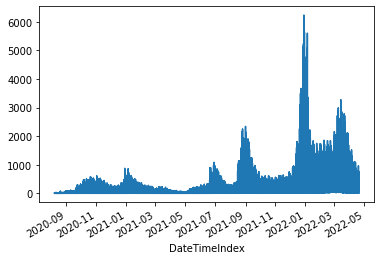

In [7]:
df['DailyPositive'].plot()
df['DailyPositive'] = np.log(3+df['DailyPositive'])
df['DailyPositive_lag_1'] = np.log(3+df['DailyPositive_lag_1'])
df['DailyPositive_lag_2'] = np.log(3+df['DailyPositive_lag_2'])
df['DailyPositive_lag_3'] = np.log(3+df['DailyPositive_lag_3'])
df['DailyPositive_lag_4'] = np.log(3+df['DailyPositive_lag_4'])
df['DailyPositive_lag_5'] = np.log(3+df['DailyPositive_lag_5'])
df['DailyPositive_lag_6'] = np.log(3+df['DailyPositive_lag_6'])
df['DailyPositive_lag_7'] = np.log(3+df['DailyPositive_lag_7'])
df['rna_value'] = np.log(10+df['rna_value'])
df['rna_lag_1'] = np.log(10+df['rna_lag_1'])
df['rna_lag_2'] = np.log(10+df['rna_lag_2'])
df['rna_lag_3'] = np.log(10+df['rna_lag_3'])
df['rna_lag_4'] = np.log(10+df['rna_lag_4'])
df['rna_lag_5'] = np.log(10+df['rna_lag_5'])
df['rna_lag_6'] = np.log(10+df['rna_lag_6'])
df['rna_lag_7'] = np.log(10+df['rna_lag_7'])

In [8]:
df_all=df

## EDA

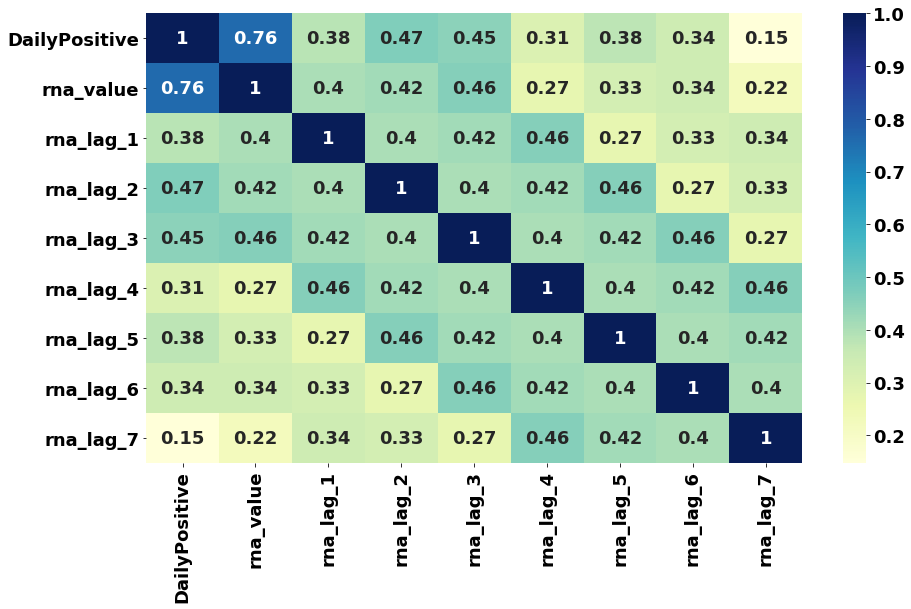

In [9]:
df1=df.iloc[:, [1,4,20,21,22,23,24,25,26]]
df1
corr = df1.corr(method='pearson')
corr
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
rcParams['figure.figsize'] = 14.7,8.27
sb.heatmap(corr, 
           xticklabels=corr.columns.values, 
          yticklabels=corr.columns.values, 
           cmap="YlGnBu",
          annot=True)
plt.savefig('heatmap1.png',bbox_inches='tight')


Plotting the RNA and daily cases by Health Board to determine the trend and possible outliers

In [10]:

a=px.line(df,x='datevar', y='rna_value',facet_col='HBName', facet_col_wrap=2,labels={
                     "rna_value": "rna"})
a.update_layout(yaxis_title="rna",font=dict(size=13))
a.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
a.write_image("Picture3_.png")
a.update_annotations(font_size=13)
a

In [11]:
b=px.line(df,x='datevar', y='DailyPositive',facet_col='HBName', facet_col_wrap=3,labels={
                     "DailyPositive": "Cases"})
#b.update_layout(font=dict(size=11))
b.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
b.write_image("Picture3_1.png")
#a.update_annotations(font_size=20)
b

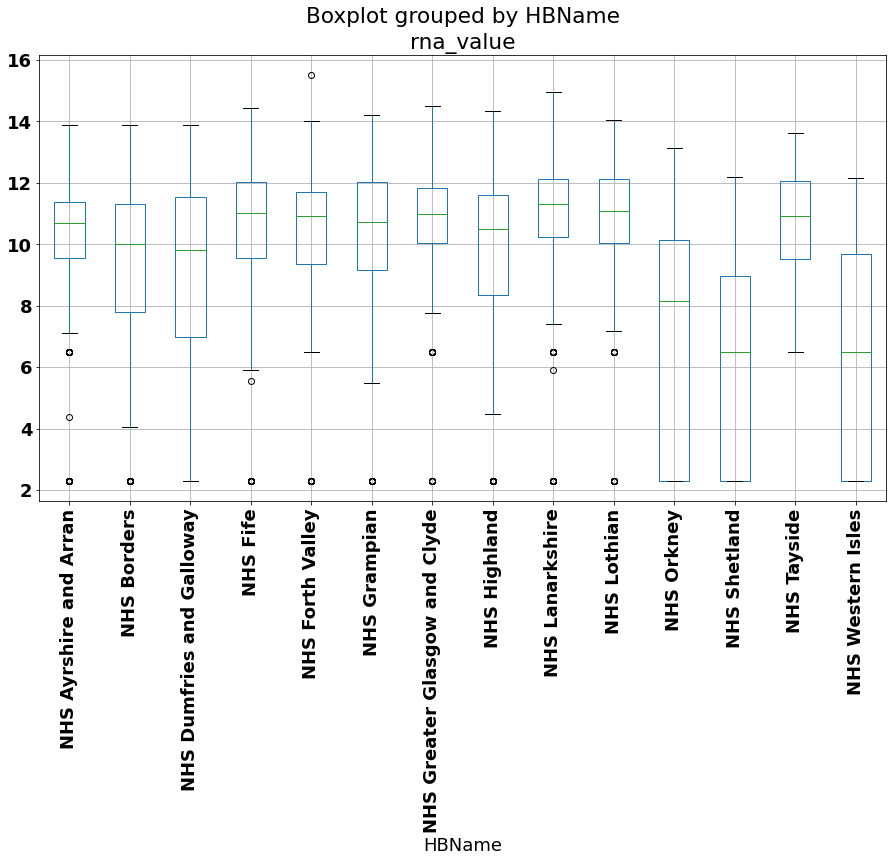

In [12]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
df.boxplot(column=['rna_value'],by='HBName')
# Rotate tick labels
plt.xticks(rotation=90)
#plt.autoscale()
# Display graph
plt.savefig('Picture3.png',bbox_inches='tight')

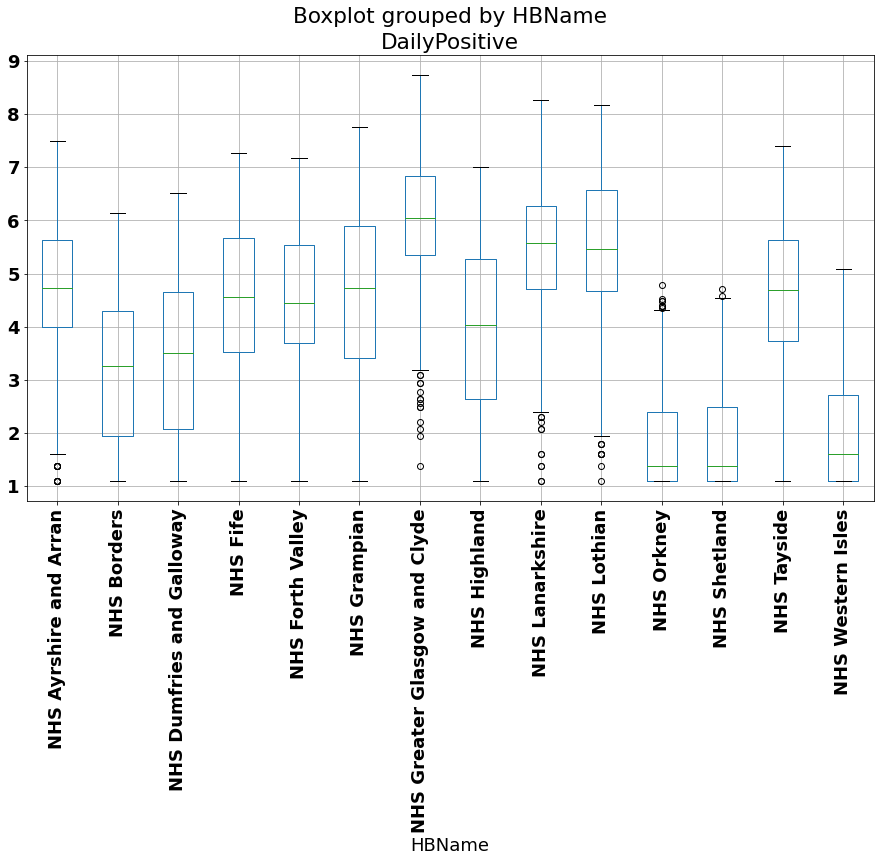

In [13]:
df.boxplot(column=['DailyPositive'],by='HBName')
# Rotate tick labels
plt.xticks(rotation=90)
#plt.autoscale()
# Display graph
plt.savefig('Picture3_1.png')

Observing the current dataframe with repeating date indices because of regional changes observed

In [14]:
df

HBName  DailyPositive  CumulativePositive  \
DateTimeIndex                                                                 
2020-08-08        NHS Ayrshire and Arran       1.386294                1291   
2020-08-08                   NHS Borders       1.098612                 341   
2020-08-08     NHS Dumfries and Galloway       1.098612                 308   
2020-08-08                      NHS Fife       1.609438                 961   
2020-08-08              NHS Forth Valley       1.098612                1104   
...                                  ...            ...                 ...   
2022-04-20                   NHS Lothian       6.428105              317386   
2022-04-20                    NHS Orkney       2.564949                5105   
2022-04-20                  NHS Shetland       3.526361                6449   
2022-04-20                   NHS Tayside       5.529429              134184   
2022-04-20             NHS Western Isles       4.060443                7531   

                 datevar  rna_value  weekday  day  NHS_Borders  \
DateTimeIndex                                                    
2020-08-08     08-Aug-20   2.302585        7  Sat            0   
2020-08-08     08-Aug-20  10.610063        7  Sat            1   
2020-08-08     08-Aug-20  11.197617        7  Sat            0   
2020-08-08     08-Aug-20  11.657104        7  Sat            0   
2020-08-08     08-Aug-20  12.126407        7  Sat            0   
...                  ...        ...      ...  ...          ...   
2022-04-20     20-Apr-22  12.115127        4  Wed            0   
2022-04-20     20-Apr-22  11.347909        4  Wed            0   
2022-04-20     20-Apr-22   9.633776        4  Wed            0   
2022-04-20     20-Apr-22  11.361823        4  Wed            0   
2022-04-20     20-Apr-22  11.842697        4  Wed            0   

               NHS_Dumfries_and_Galloway  NHS_Fife  ...  rna_lag_5  rna_lag_6  \
DateTimeIndex                                       ...                         
2020-08-08                             0         0  ...        NaN        NaN   
2020-08-08                             0         0  ...        NaN        NaN   
2020-08-08                             1         0  ...        NaN        NaN   
2020-08-08                             0         1  ...        NaN        NaN   
2020-08-08                             0         0  ...        NaN        NaN   
...                                  ...       ...  ...        ...        ...   
2022-04-20                             0         0  ...  12.020845  12.126407   
2022-04-20                             0         0  ...  10.755306  12.020845   
2022-04-20                             0         0  ...  11.173729  10.755306   
2022-04-20                             0         0  ...  10.986641  11.173729   
2022-04-20                             0         0  ...  11.118252  10.986641   

               rna_lag_7  DailyPositive_lag_1  DailyPositive_lag_2  \
DateTimeIndex                                                        
2020-08-08           NaN                  NaN                  NaN   
2020-08-08           NaN             1.386294                  NaN   
2020-08-08           NaN             1.098612             1.386294   
2020-08-08           NaN             1.098612             1.098612   
2020-08-08           NaN             1.609438             1.098612   
...                  ...                  ...                  ...   
2022-04-20     11.657104             6.066108             5.560682   
2022-04-20     12.126407             6.428105             6.066108   
2022-04-20     12.020845             2.564949             6.428105   
2022-04-20     10.755306             3.526361             2.564949   
2022-04-20     11.173729             5.529429             3.526361   

               DailyPositive_lag_3  DailyPositive_lag_4  DailyPositive_lag_5  \
DateTimeIndex                                                                  
2020-08-08            

# Analysis

Summing up the values corresponding to same date index to get a daily indexed data and creating a 95% train set and 5% test set

In [15]:
dataset_len = len(df)
split_index = round(dataset_len*0.95)
train_set_end_date = df.index[split_index]
df_train = df.loc[df.index <= train_set_end_date].copy()
df_test = df.loc[df.index > train_set_end_date].copy()
df_test

HBName  DailyPositive  CumulativePositive  \
DateTimeIndex                                                                 
2022-03-21        NHS Ayrshire and Arran       7.115582              121495   
2022-03-21                   NHS Borders       5.690359               27616   
2022-03-21     NHS Dumfries and Galloway       5.755742               38305   
2022-03-21                      NHS Fife       6.776507              112095   
2022-03-21              NHS Forth Valley       6.788972              100671   
...                                  ...            ...                 ...   
2022-04-20                   NHS Lothian       6.428105              317386   
2022-04-20                    NHS Orkney       2.564949                5105   
2022-04-20                  NHS Shetland       3.526361                6449   
2022-04-20                   NHS Tayside       5.529429              134184   
2022-04-20             NHS Western Isles       4.060443                7531   

                 datevar  rna_value  weekday  day  NHS_Borders  \
DateTimeIndex                                                    
2022-03-21     21-Mar-22  12.390189        2  Mon            0   
2022-03-21     21-Mar-22  12.782534        2  Mon            1   
2022-03-21     21-Mar-22  11.900898        2  Mon            0   
2022-03-21     21-Mar-22  12.754099        2  Mon            0   
2022-03-21     21-Mar-22  13.051110        2  Mon            0   
...                  ...        ...      ...  ...          ...   
2022-04-20     20-Apr-22  12.115127        4  Wed            0   
2022-04-20     20-Apr-22  11.347909        4  Wed            0   
2022-04-20     20-Apr-22   9.633776        4  Wed            0   
2022-04-20     20-Apr-22  11.361823        4  Wed            0   
2022-04-20     20-Apr-22  11.842697        4  Wed            0   

               NHS_Dumfries_and_Galloway  NHS_Fife  ...  rna_lag_5  rna_lag_6  \
DateTimeIndex                                       ...                         
2022-03-21                             0         0  ...  13.224221  13.014595   
2022-03-21                             0         0  ...  12.487802  13.224221   
2022-03-21                             1         0  ...   9.160415  12.487802   
2022-03-21                             0         1  ...  12.985567   9.160415   
2022-03-21                             0         0  ...  12.021007  12.985567   
...                                  ...       ...  ...        ...        ...   
2022-04-20                             0         0  ...  12.020845  12.126407   
2022-04-20                             0         0  ...  10.755306  12.020845   
2022-04-20                             0         0  ...  11.173729  10.755306   
2022-04-20                             0         0  ...  10.986641  11.173729   
2022-04-20                             0         0  ...  11.118252  10.986641   

               rna_lag_7  DailyPositive_lag_1  DailyPositive_lag_2  \
DateTimeIndex                                                        
2022-03-21     13.780740             4.955827             6.548219   
2022-03-21     13.014595             7.115582             4.955827   
2022-03-21     13.224221             5.690359             7.115582   
2022-03-21     12.487802             5.755742             5.690359   
2022-03-21      9.160415             6.776507             5.755742   
...                  ...                  ...                  ...   
2022-04-20     11.657104             6.066108             5.560682   
2022-04-20     12.126407             6.428105             6.066108   
2022-04-20     12.020845             2.564949             6.428105   
2022-04-20     10.755306             3.526361             2.564949   
2022-04-20     11.173729             5.529429             3.526361   

               DailyPositive_lag_3  DailyPositive_lag_4  DailyPositive_lag_5  \
DateTimeIndex                                                                  
2022-03-21            

Plotting correlation for data converted to daily

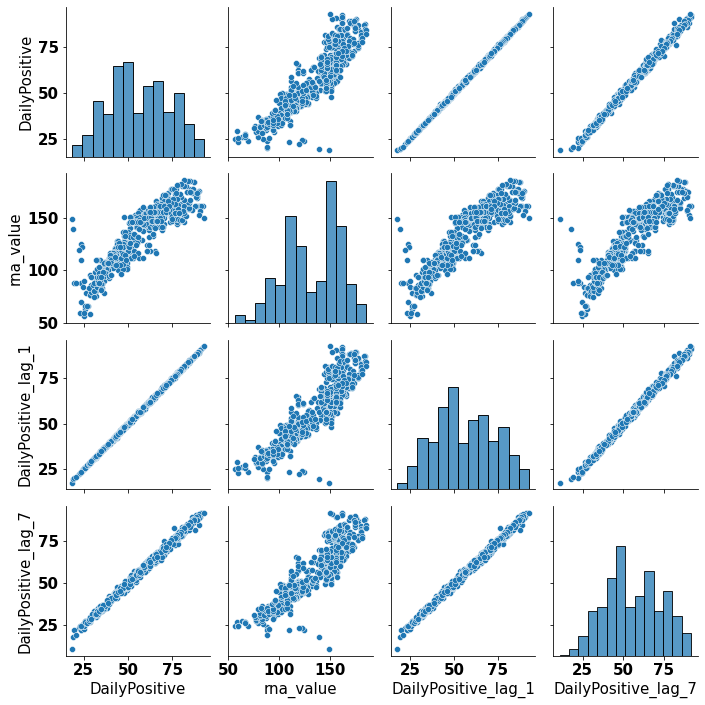

In [16]:
df_1=df.groupby(df.index).sum()
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 15}

plt.rc('font', **font)
df2=df_1.iloc[:, [0,2,24,30]]
sns.pairplot(data=df2)
#sns.set(font_scale=2)
plt.savefig('correl.png',bbox_inches='tight')

In [17]:
df_test

HBName  DailyPositive  CumulativePositive  \
DateTimeIndex                                                                 
2022-03-21        NHS Ayrshire and Arran       7.115582              121495   
2022-03-21                   NHS Borders       5.690359               27616   
2022-03-21     NHS Dumfries and Galloway       5.755742               38305   
2022-03-21                      NHS Fife       6.776507              112095   
2022-03-21              NHS Forth Valley       6.788972              100671   
...                                  ...            ...                 ...   
2022-04-20                   NHS Lothian       6.428105              317386   
2022-04-20                    NHS Orkney       2.564949                5105   
2022-04-20                  NHS Shetland       3.526361                6449   
2022-04-20                   NHS Tayside       5.529429              134184   
2022-04-20             NHS Western Isles       4.060443                7531   

                 datevar  rna_value  weekday  day  NHS_Borders  \
DateTimeIndex                                                    
2022-03-21     21-Mar-22  12.390189        2  Mon            0   
2022-03-21     21-Mar-22  12.782534        2  Mon            1   
2022-03-21     21-Mar-22  11.900898        2  Mon            0   
2022-03-21     21-Mar-22  12.754099        2  Mon            0   
2022-03-21     21-Mar-22  13.051110        2  Mon            0   
...                  ...        ...      ...  ...          ...   
2022-04-20     20-Apr-22  12.115127        4  Wed            0   
2022-04-20     20-Apr-22  11.347909        4  Wed            0   
2022-04-20     20-Apr-22   9.633776        4  Wed            0   
2022-04-20     20-Apr-22  11.361823        4  Wed            0   
2022-04-20     20-Apr-22  11.842697        4  Wed            0   

               NHS_Dumfries_and_Galloway  NHS_Fife  ...  rna_lag_5  rna_lag_6  \
DateTimeIndex                                       ...                         
2022-03-21                             0         0  ...  13.224221  13.014595   
2022-03-21                             0         0  ...  12.487802  13.224221   
2022-03-21                             1         0  ...   9.160415  12.487802   
2022-03-21                             0         1  ...  12.985567   9.160415   
2022-03-21                             0         0  ...  12.021007  12.985567   
...                                  ...       ...  ...        ...        ...   
2022-04-20                             0         0  ...  12.020845  12.126407   
2022-04-20                             0         0  ...  10.755306  12.020845   
2022-04-20                             0         0  ...  11.173729  10.755306   
2022-04-20                             0         0  ...  10.986641  11.173729   
2022-04-20                             0         0  ...  11.118252  10.986641   

               rna_lag_7  DailyPositive_lag_1  DailyPositive_lag_2  \
DateTimeIndex                                                        
2022-03-21     13.780740             4.955827             6.548219   
2022-03-21     13.014595             7.115582             4.955827   
2022-03-21     13.224221             5.690359             7.115582   
2022-03-21     12.487802             5.755742             5.690359   
2022-03-21      9.160415             6.776507             5.755742   
...                  ...                  ...                  ...   
2022-04-20     11.657104             6.066108             5.560682   
2022-04-20     12.126407             6.428105             6.066108   
2022-04-20     12.020845             2.564949             6.428105   
2022-04-20     10.755306             3.526361             2.564949   
2022-04-20     11.173729             5.529429             3.526361   

               DailyPositive_lag_3  DailyPositive_lag_4  DailyPositive_lag_5  \
DateTimeIndex                                                                  
2022-03-21            

Creating a linear model with RNA value, it's 7 lags and 13 dummy variables of 14 health regions and fitting Ordinary Least Square Regression

In [18]:
expr = 'DailyPositive ~ rna_value+rna_lag_1+rna_lag_2+rna_lag_3+rna_lag_4+rna_lag_5+rna_lag_6+rna_lag_7+NHS_Borders+NHS_Dumfries_and_Galloway+NHS_Fife+NHS_Forth_Valley+NHS_Grampian+NHS_Greater_Glasgow_and_Clyde+NHS_Highland+NHS_Lanarkshire+NHS_Lothian+NHS_Orkney+NHS_Shetland+NHS_Tayside+NHS_Western_Isles+weekday'

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
olsr_results = linear_model.OLS(y_train, X_train).fit()
olsr_results.summary()
print(olsr_results.summary())

#Converting to latex table
for table in olsr_results.summary().tables:
    print(table.as_latex_tabular())

                            OLS Regression Results                            
Dep. Variable:          DailyPositive   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     1979.
Date:                Wed, 07 Sep 2022   Prob (F-statistic):               0.00
Time:                        16:28:47   Log-Likelihood:                -9141.8
No. Observations:                8253   AIC:                         1.833e+04
Df Residuals:                    8230   BIC:                         1.849e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [19]:
y_pred=olsr_results.predict(X_test)
y_pred=pd.DataFrame(y_pred)
pred=pd.concat([y_test, y_pred], axis=1)
mapping = {pred.columns[0]:'DailyPositive_actual', pred.columns[1]: 'DailyPositive_predictions'}
pred = pred.rename(columns=mapping)
pred

DailyPositive_actual  DailyPositive_predictions
DateTimeIndex                                                 
2022-03-21                 7.115582                   6.411528
2022-03-21                 5.690359                   5.074700
2022-03-21                 5.755742                   5.299357
2022-03-21                 6.776507                   6.290746
2022-03-21                 6.788972                   6.173283
...                             ...                        ...
2022-04-20                 6.428105                   6.087762
2022-04-20                 2.564949                   2.708625
2022-04-20                 3.526361                   2.864584
2022-04-20                 5.529429                   5.458935
2022-04-20                 4.060443                   3.305983

[434 rows x 2 columns]

In [20]:
mse = ((pred["DailyPositive_predictions"] - pred["DailyPositive_actual"]) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 0.2
The Root Mean Squared Error of our forecasts is 0.44


In [21]:
#perform White's test
white_test = het_white(olsr_results.resid,  olsr_results.model.exog)

#define labels to use for output of White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

#print results of White's test
print(dict(zip(labels, white_test)))

#p<0.05, reject the null hypothesis of homoscedasticity. The residuals are heteroscedastic

{'Test Statistic': 2043.2325468129902, 'Test Statistic p-value': 1.1813383220382e-310, 'F-Statistic': 14.427481551162554, 'F-Test p-value': 0.0}


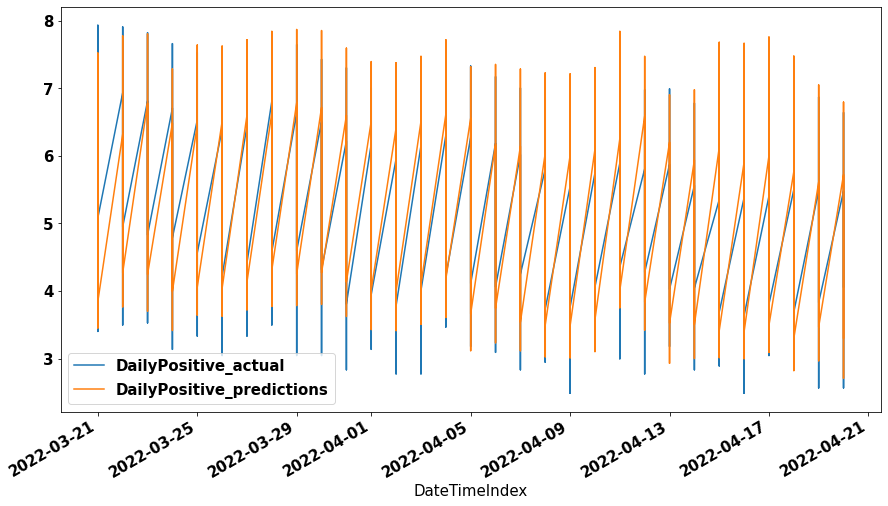

In [22]:
pred.plot(use_index=True)
plt.savefig('linear_reg.png')

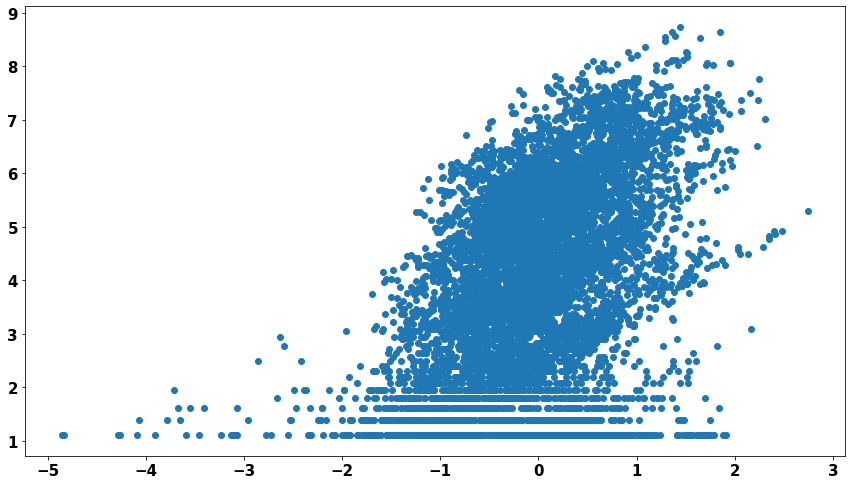

In [23]:
pyplot.scatter(olsr_results.resid,y_train)

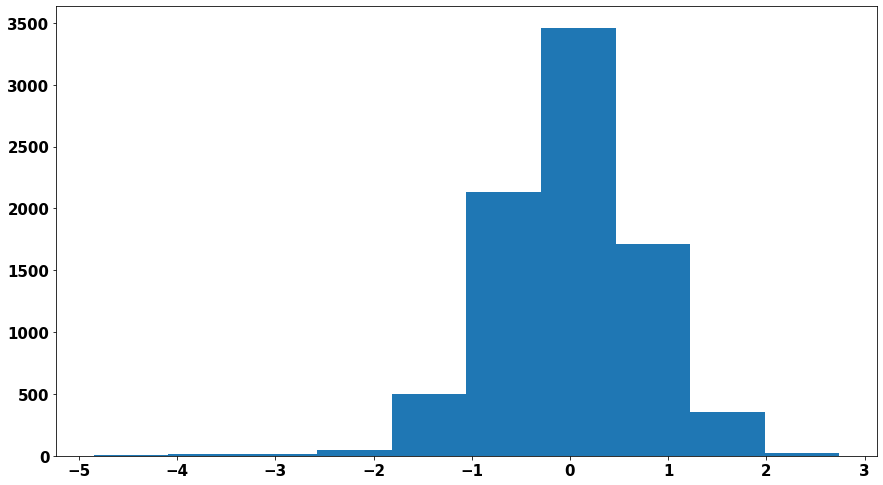

In [24]:
pyplot.hist(olsr_results.resid)
plt.savefig('hist.png')

C:\Users\simon\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



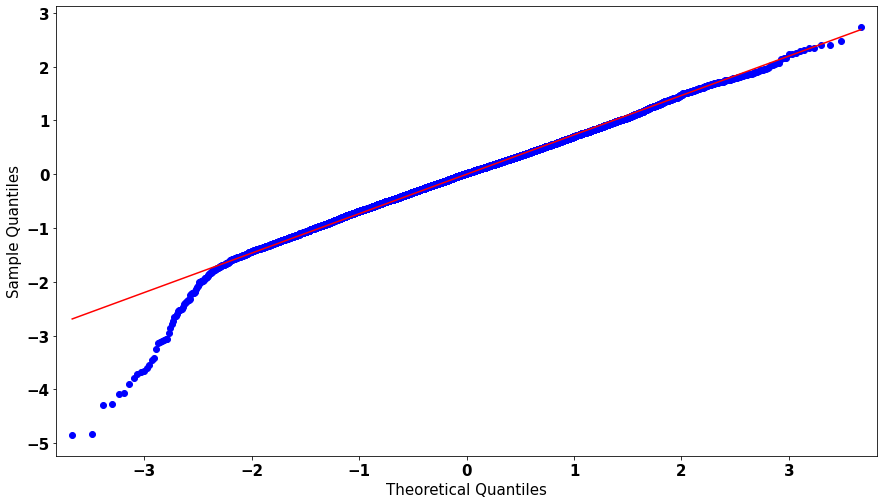

In [25]:
qqplot(olsr_results.resid,line='s')
plt.savefig('qq.png')

In [26]:
#Predictions
predictions_act=np.exp(y_pred)
predictions_act

0
DateTimeIndex            
2022-03-21     608.823395
2022-03-21     159.924225
2022-03-21     200.208028
2022-03-21     539.555437
2022-03-21     479.758462
...                   ...
2022-04-20     440.434660
2022-04-20      15.008620
2022-04-20      17.541752
2022-04-20     234.847249
2022-04-20      27.275335

[434 rows x 1 columns]

In [27]:
#Actual values
np.exp(y_test)

DailyPositive
DateTimeIndex               
2022-03-21            1231.0
2022-03-21             296.0
2022-03-21             316.0
2022-03-21             877.0
2022-03-21             888.0
...                      ...
2022-04-20             619.0
2022-04-20              13.0
2022-04-20              34.0
2022-04-20             252.0
2022-04-20              58.0

[434 rows x 1 columns]

Using SARIMAX model by residual modelling for daily data

In [28]:
df_dum

HBName  DailyPositive  CumulativePositive  \
DateTimeIndex                                                                 
2020-08-08        NHS Ayrshire and Arran       1.386294                1291   
2020-08-08                   NHS Borders       1.098612                 341   
2020-08-08     NHS Dumfries and Galloway       1.098612                 308   
2020-08-08                      NHS Fife       1.609438                 961   
2020-08-08              NHS Forth Valley       1.098612                1104   
...                                  ...            ...                 ...   
2022-04-20                   NHS Lothian       6.428105              317386   
2022-04-20                    NHS Orkney       2.564949                5105   
2022-04-20                  NHS Shetland       3.526361                6449   
2022-04-20                   NHS Tayside       5.529429              134184   
2022-04-20             NHS Western Isles       4.060443                7531   

                 datevar  rna_value  weekday  day  NHS_Borders  \
DateTimeIndex                                                    
2020-08-08     08-Aug-20   2.302585        7  Sat            0   
2020-08-08     08-Aug-20  10.610063        7  Sat            1   
2020-08-08     08-Aug-20  11.197617        7  Sat            0   
2020-08-08     08-Aug-20  11.657104        7  Sat            0   
2020-08-08     08-Aug-20  12.126407        7  Sat            0   
...                  ...        ...      ...  ...          ...   
2022-04-20     20-Apr-22  12.115127        4  Wed            0   
2022-04-20     20-Apr-22  11.347909        4  Wed            0   
2022-04-20     20-Apr-22   9.633776        4  Wed            0   
2022-04-20     20-Apr-22  11.361823        4  Wed            0   
2022-04-20     20-Apr-22  11.842697        4  Wed            0   

               NHS_Dumfries_and_Galloway  NHS_Fife  ...  rna_lag_5  rna_lag_6  \
DateTimeIndex                                       ...                         
2020-08-08                             0         0  ...        NaN        NaN   
2020-08-08                             0         0  ...        NaN        NaN   
2020-08-08                             1         0  ...        NaN        NaN   
2020-08-08                             0         1  ...        NaN        NaN   
2020-08-08                             0         0  ...        NaN        NaN   
...                                  ...       ...  ...        ...        ...   
2022-04-20                             0         0  ...  12.020845  12.126407   
2022-04-20                             0         0  ...  10.755306  12.020845   
2022-04-20                             0         0  ...  11.173729  10.755306   
2022-04-20                             0         0  ...  10.986641  11.173729   
2022-04-20                             0         0  ...  11.118252  10.986641   

               rna_lag_7  DailyPositive_lag_1  DailyPositive_lag_2  \
DateTimeIndex                                                        
2020-08-08           NaN                  NaN                  NaN   
2020-08-08           NaN             1.386294                  NaN   
2020-08-08           NaN             1.098612             1.386294   
2020-08-08           NaN             1.098612             1.098612   
2020-08-08           NaN             1.609438             1.098612   
...                  ...                  ...                  ...   
2022-04-20     11.657104             6.066108             5.560682   
2022-04-20     12.126407             6.428105             6.066108   
2022-04-20     12.020845             2.564949             6.428105   
2022-04-20     10.755306             3.526361             2.564949   
2022-04-20     11.173729             5.529429             3.526361   

               DailyPositive_lag_3  DailyPositive_lag_4  DailyPositive_lag_5  \
DateTimeIndex                                                                  
2020-08-08            

In [29]:
df_dum=df_dum.groupby(df_dum.index).sum()
df_dum

DailyPositive  CumulativePositive   rna_value  weekday  \
DateTimeIndex                                                           
2020-08-08         18.626246               19064  148.407186       98   
2020-08-09         19.259970               19090  139.052667       14   
2020-08-10         23.431050               19148  124.485962       28   
2020-08-11         24.071407               19213  122.269491       42   
2020-08-12         22.173010               19261  118.825136       56   
...                      ...                 ...         ...      ...   
2022-04-16         69.789918             1887902  171.301692       98   
2022-04-17         70.595495             1891203  171.301692       14   
2022-04-18         72.471235             1895083  165.405069       28   
2022-04-19         72.821178             1899326  161.393983       42   
2022-04-20         71.520807             1902962  157.947298       56   

               NHS_Borders  NHS_Dumfries_and_Galloway  NHS_Fife  \
DateTimeIndex                                                     
2020-08-08               1                          1         1   
2020-08-09               1                          1         1   
2020-08-10               1                          1         1   
2020-08-11               1                          1         1   
2020-08-12               1                          1         1   
...                    ...                        ...       ...   
2022-04-16               1                          1         1   
2022-04-17               1                          1         1   
2022-04-18               1                          1         1   
2022-04-19               1                          1         1   
2022-04-20               1                          1         1   

               NHS_Forth_Valley  NHS_Grampian  NHS_Greater_Glasgow_and_Clyde  \
DateTimeIndex                                                                  
2020-08-08                    1             1                              1   
2020-08-09                    1             1                              1   
2020-08-10                    1             1                              1   
2020-08-11                    1             1                              1   
2020-08-12                    1             1                              1   
...                         ...           ...                            ...   
2022-04-16                    1             1                              1   
2022-04-17                    1             1                              1   
2022-04-18                    1             1                              1   
2022-04-19                    1             1                              1   
2022-04-20                    1             1                              1   

               ...   rna_lag_5   rna_lag_6   rna_lag_7  DailyPositive_lag_1  \
DateTimeIndex  ...                                                            
2020-08-08     ...   92.830297   81.843656   70.669927            17.527634   
2020-08-09     ...  139.052667  139.052667  139.052667            19.259970   
2020-08-10     ...  124.485962  133.170019  142.041163            23.431050   
2020-08-11     ...  122.269491  122.269491  122.269491            24.071407   
2020-08-12     ...  122.269491  122.269491  122.269491            22.173010   
...            ...         ...         ...         ...                  ...   
2022-04-16     ...  171.301692  171.301692  171.301692            69.841211   
2022-04-17     ...  171.301692  171.301692  171.301692            70.426419   
2022-04-18     ...  167.000332  167.000332  168.038019            72.589018   
2022-04-19     ...  164.020813  158.829516  158.829516            72.681416   
2022-04-20     ...  157.544938  158.122272  159.289626            71.289006   

               DailyPositive_lag_2  DailyPositive_lag_3  DailyPositive_lag_4  \
DateTimeIndex                               

In [30]:
df_dum['DailyPositive'] = np.log(df_dum['DailyPositive'])
df_dum['DailyPositive_lag_1'] = np.log(df_dum['DailyPositive_lag_1'])
df_dum['DailyPositive_lag_2'] = np.log(df_dum['DailyPositive_lag_2'])
df_dum['DailyPositive_lag_3'] = np.log(df_dum['DailyPositive_lag_3'])
df_dum['DailyPositive_lag_4'] = np.log(df_dum['DailyPositive_lag_4'])
df_dum['DailyPositive_lag_5'] = np.log(df_dum['DailyPositive_lag_5'])
df_dum['DailyPositive_lag_6'] = np.log(df_dum['DailyPositive_lag_6'])
df_dum['DailyPositive_lag_7'] = np.log(df_dum['DailyPositive_lag_7'])
df_dum['rna_value'] = np.log(df_dum['rna_value'])
df_dum['rna_lag_1'] = np.log(df_dum['rna_lag_1'])
df_dum['rna_lag_2'] = np.log(df_dum['rna_lag_2'])
df_dum['rna_lag_3'] = np.log(df_dum['rna_lag_3'])
df_dum['rna_lag_4'] = np.log(df_dum['rna_lag_4'])
df_dum['rna_lag_5'] = np.log(df_dum['rna_lag_5'])
df_dum['rna_lag_6'] = np.log(df_dum['rna_lag_6'])
df_dum['rna_lag_7'] = np.log(df_dum['rna_lag_7'])

In [31]:
dataset_len = len(df_dum)
split_index = round(dataset_len*0.95)
train_set_end_date = df_dum.index[split_index]
df_train1 = df_dum.loc[df_dum.index <= train_set_end_date].copy()
df_test1 = df_dum.loc[df_dum.index > train_set_end_date].copy()

In [32]:
df_test1

DailyPositive  CumulativePositive  rna_value  weekday  \
DateTimeIndex                                                          
2022-03-22          4.469910             1725062   5.213247       42   
2022-03-23          4.465934             1736831   5.212758       56   
2022-03-24          4.442158             1747212   5.158318       70   
2022-03-25          4.417262             1756028   5.193450       84   
2022-03-26          4.383817             1763244   5.193450       98   
2022-03-27          4.401088             1771068   5.193450       14   
2022-03-28          4.440731             1781328   5.218120       28   
2022-03-29          4.430318             1791078   5.219995       42   
2022-03-30          4.403801             1799222   5.222605       56   
2022-03-31          4.367530             1805992   5.195640       70   
2022-04-01          4.341336             1811603   5.176789       84   
2022-04-02          4.316559             1816457   5.176789       98   
2022-04-03          4.331323             1821776   5.176789       14   
2022-04-04          4.380431             1828567   5.201091       28   
2022-04-05          4.380569             1835579   5.132079       42   
2022-04-06          4.369907             1841999   5.147403       56   
2022-04-07          4.355227             1847670   5.123552       70   
2022-04-08          4.316016             1852272   5.121138       84   
2022-04-09          4.281998             1856358   5.121138       98   
2022-04-10          4.320357             1860746   5.121138       14   
2022-04-11          4.349948             1866290   5.198634       28   
2022-04-12          4.340895             1871594   5.153888       42   
2022-04-13          4.333494             1876729   5.089984       56   
2022-04-14          4.308205             1881049   5.097890       70   
2022-04-15          4.269409             1884680   5.143426       84   
2022-04-16          4.245490             1887902   5.143426       98   
2022-04-17          4.256966             1891203   5.143426       14   
2022-04-18          4.283190             1895083   5.108397       28   
2022-04-19          4.288007             1899326   5.083848       42   
2022-04-20          4.269988             1902962   5.062261       56   

               NHS_Borders  NHS_Dumfries_and_Galloway  NHS_Fife  \
DateTimeIndex                                                     
2022-03-22               1                          1         1   
2022-03-23               1                          1         1   
2022-03-24               1                          1         1   
2022-03-25               1                          1         1   
2022-03-26               1                          1         1   
2022-03-27               1                          1         1   
2022-03-28               1                          1         1   
2022-03-29               1                          1         1   
2022-03-30               1                          1         1   
2022-03-31               1                          1         1   
2022-04-01               1                          1         1   
2022-04-02               1                          1         1   
2022-04-03               1                          1         1   
2022-04-04               1                          1         1   
2022-04-05               1                          1         1   
2022-04-06               1                          1         1   
2022-04-07               1                          1         1   
2022-04-08               1                          1         1   
2022-04-09               1                          1         1   
2022-04-10               1                          1         1   
2022-04-11               1                          1         1   
2022-04-12               1                          1         1   
2022-04-13               1                          1         1   
2022-04-14               1         

In [33]:
expr = 'DailyPositive ~ rna_value+rna_lag_1+rna_lag_2+rna_lag_3+rna_lag_4+rna_lag_5+rna_lag_6+rna_lag_7+NHS_Borders+NHS_Dumfries_and_Galloway+NHS_Fife+NHS_Forth_Valley+NHS_Grampian+NHS_Greater_Glasgow_and_Clyde+NHS_Highland+NHS_Lanarkshire+NHS_Lothian+NHS_Orkney+NHS_Shetland+NHS_Tayside+NHS_Western_Isles+weekday'

y_train1, X_train1 = dmatrices(expr, df_train1, return_type='dataframe')
y_test1, X_test1 = dmatrices(expr, df_test1, return_type='dataframe')
olsr_results = linear_model.OLS(y_train1, X_train1).fit()
olsr_results.summary()
print(olsr_results.summary())

#Converting to latex table
for table in olsr_results.summary().tables:
    print(table.as_latex_tabular())

                            OLS Regression Results                            
Dep. Variable:          DailyPositive   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     250.3
Date:                Wed, 07 Sep 2022   Prob (F-statistic):          1.98e-193
Time:                        16:28:49   Log-Likelihood:                 295.65
No. Observations:                 591   AIC:                            -571.3
Df Residuals:                     581   BIC:                            -527.5
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

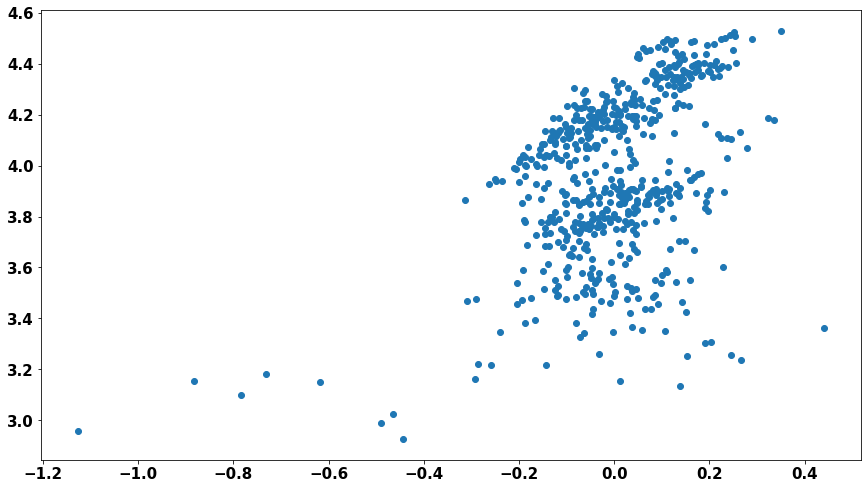

In [34]:
pyplot.scatter(olsr_results.resid,y_train1)
plt.savefig('linear_resid.png')

Checking the stationarity of the residuals

In [35]:
adf_rez =statsmodels.tsa.stattools.adfuller(olsr_results.resid)
print("p-value for Dickey-Fuller test of stationarity is {0:.4f}, meaning that the time series is non-stationary".format(adf_rez[1]))

p-value for Dickey-Fuller test of stationarity is 0.0721, meaning that the time series is non-stationary


decomposing the residuals

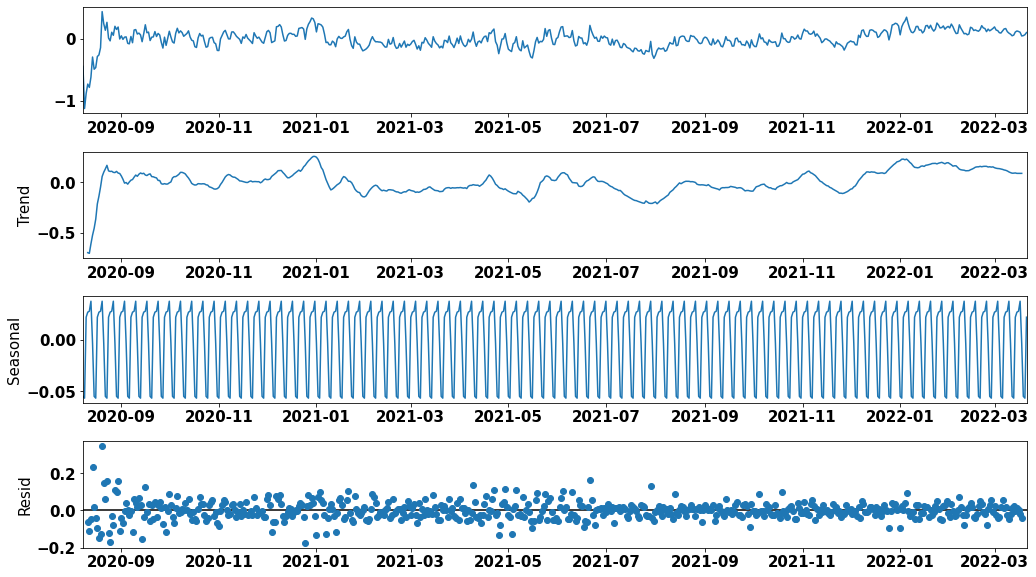

In [36]:
residual=olsr_results.resid
components = seasonal_decompose(residual)
components.plot()
plt.savefig('seasonal_decomp.png')

Plotting ACF and PACF of the residuals

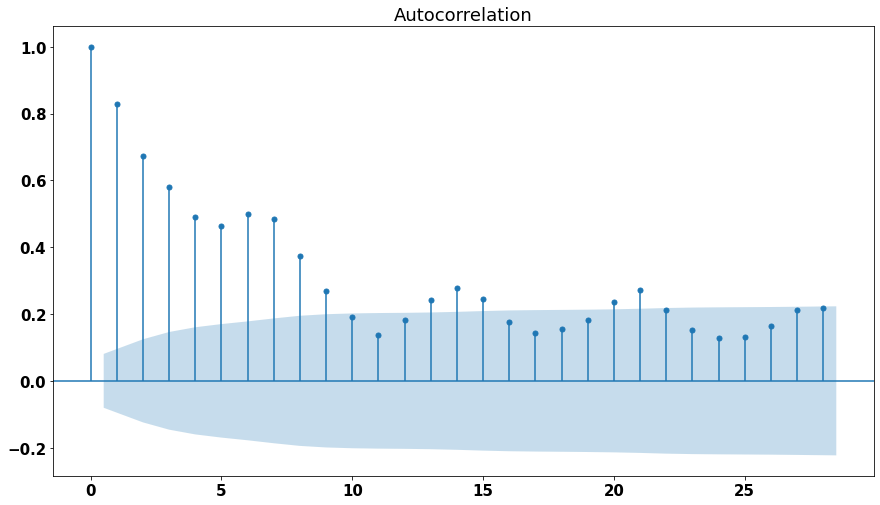

In [37]:
tsa.plot_acf(residual, alpha=0.05)

plt.savefig('ACF.png')

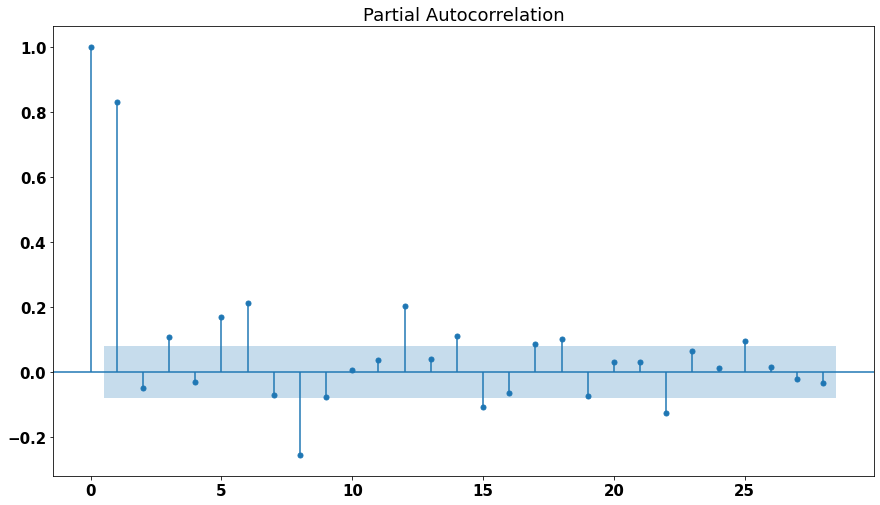

In [38]:
tsa.plot_pacf(olsr_results.resid, alpha=0.05)

plt.savefig('PACF.png')

In [39]:
olsr_resid_diff_1 = residual.diff()
olsr_resid_diff_1 = olsr_resid_diff_1.dropna()

In [40]:
adf_rez =statsmodels.tsa.stattools.adfuller(olsr_resid_diff_1)
print("p-value for Dickey-Fuller test of stationarity is {0:.4f}, meaning that the time series is stationary".format(adf_rez[1]))

p-value for Dickey-Fuller test of stationarity is 0.0000, meaning that the time series is stationary


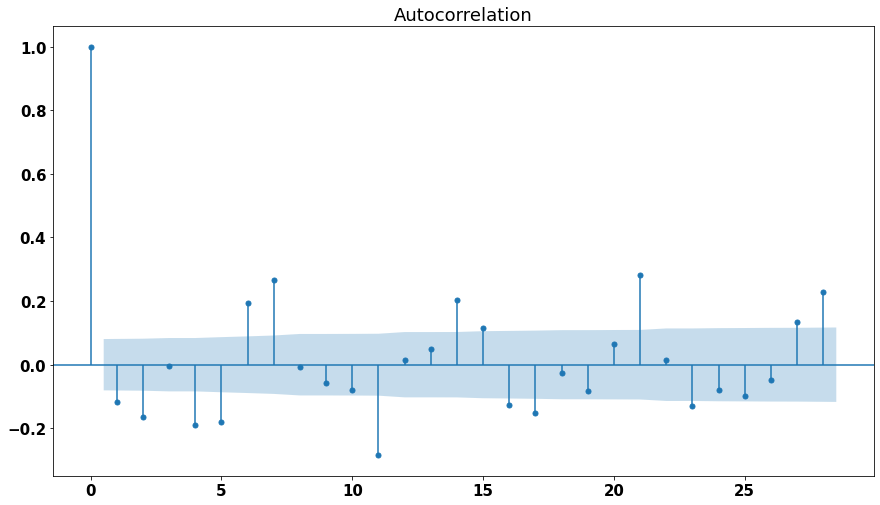

In [41]:
tsa.plot_acf(olsr_resid_diff_1, alpha=0.05)

plt.savefig('ACF_diff.png')
#Since lag-1 correlation is negative no further differencing is needed
#strong negative correlation at lag=1 p cannot be 1 ............so d=1, q=0,p=0

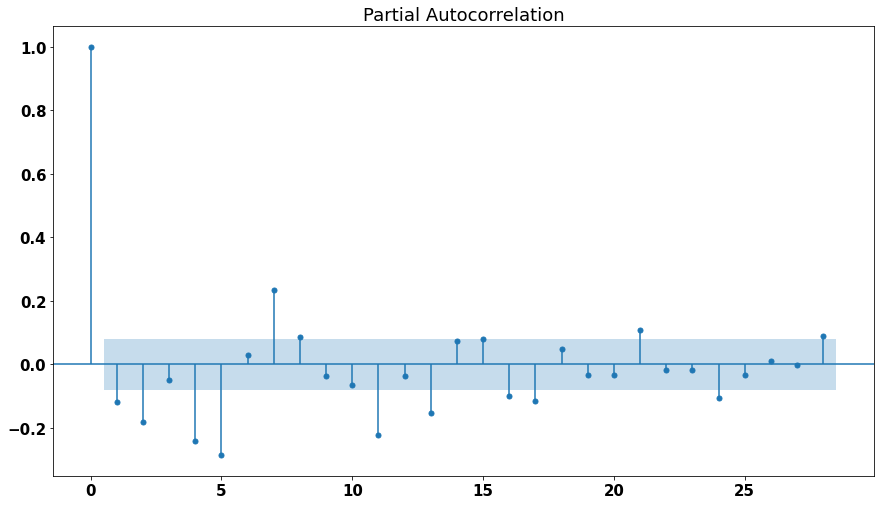

In [42]:
tsa.plot_pacf(olsr_resid_diff_1, alpha=0.05)
plt.savefig('PACF_diff.png')

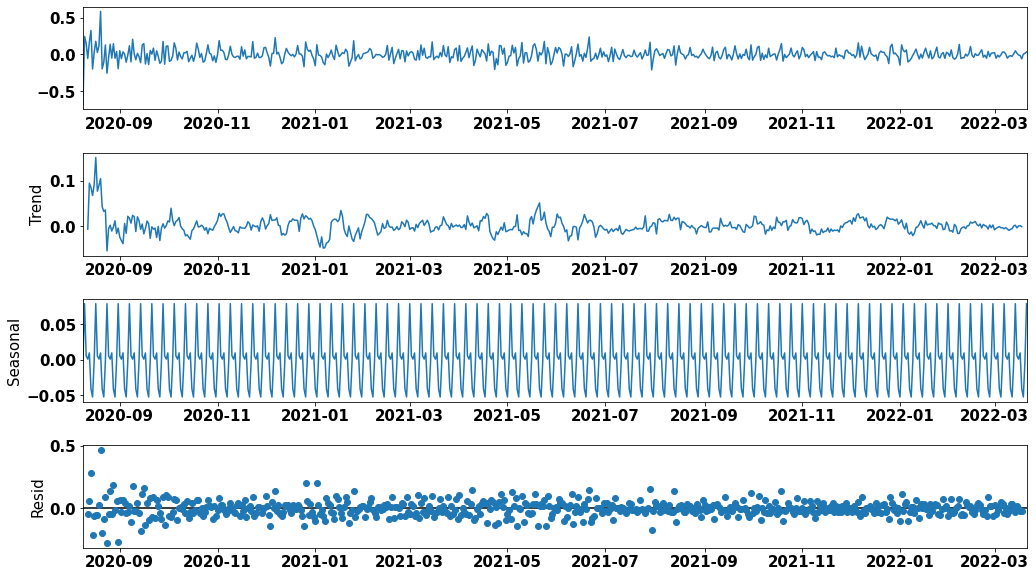

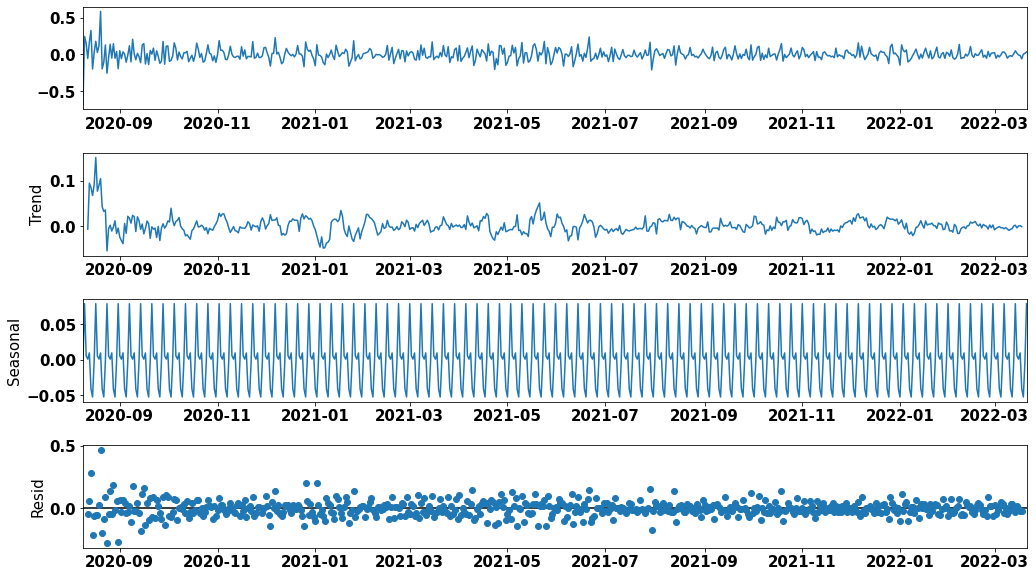

In [43]:
components = seasonal_decompose(olsr_resid_diff_1)
components.plot()

<AxesSubplot:xlabel='DateTimeIndex'>

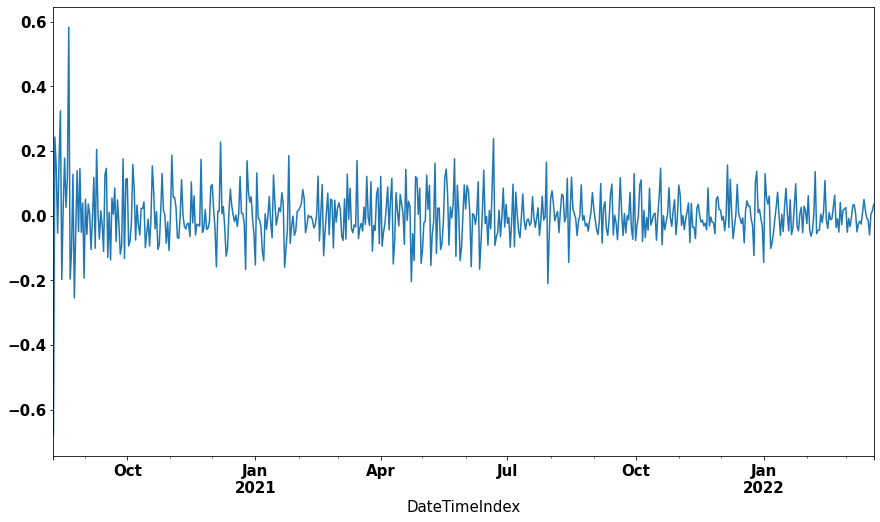

In [44]:
olsr_resid_diff_1.plot()

<AxesSubplot:xlabel='DateTimeIndex'>

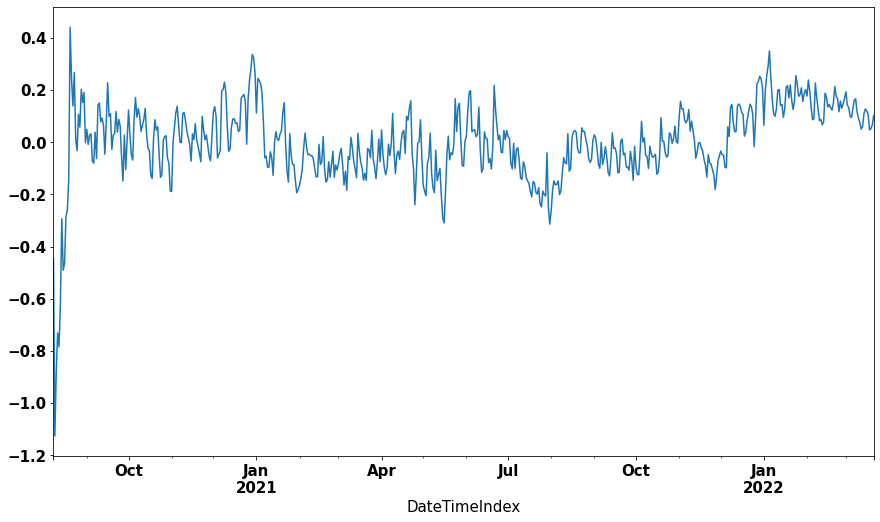

In [45]:
olsr_results.resid.plot()

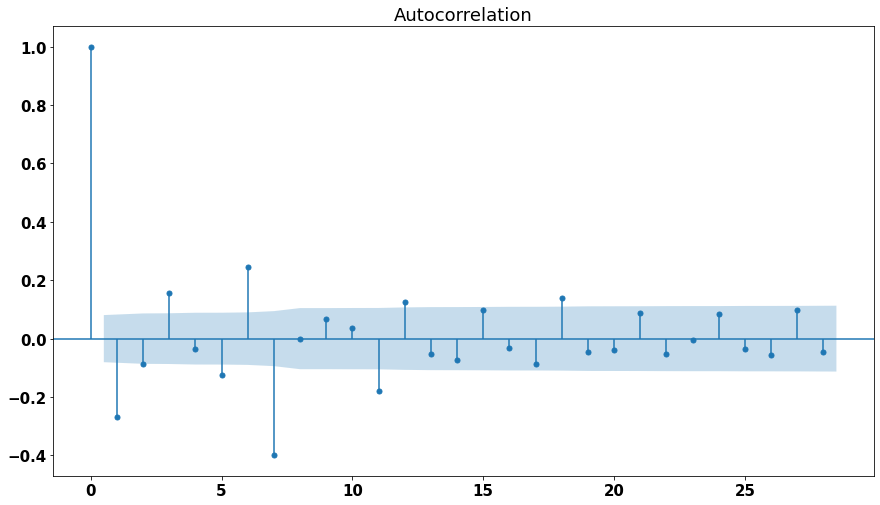

In [46]:
#since data given is weekly find any weekly changes
olsr_resid_diff_1_7=olsr_resid_diff_1.diff(periods=7)
olsr_resid_diff_1_7=olsr_resid_diff_1_7.fillna(0)
tsa.plot_acf(olsr_resid_diff_1_7, alpha=0.05)
plt.savefig('ACF_weekly_diff.png')
#strong negative correlation at lag=7 p cannot be 1............so D=1, Q=1,P=0

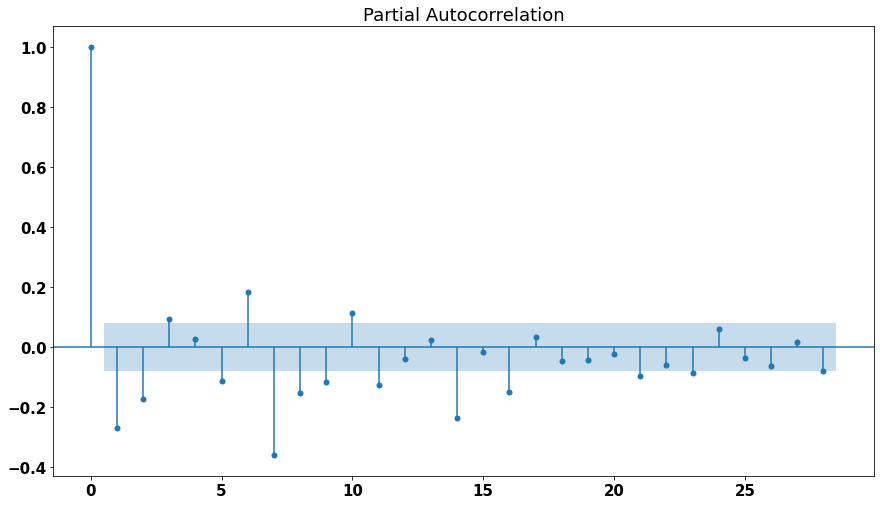

In [47]:
tsa.plot_pacf(olsr_resid_diff_1_7, alpha=0.05)
plt.savefig('PACF_weekly_diff.png')

In [48]:
olsr_resid_diff_1_7

DateTimeIndex
2020-08-09    0.000000
2020-08-10    0.000000
2020-08-11    0.000000
2020-08-12    0.000000
2020-08-13    0.000000
                ...   
2022-03-17    0.010557
2022-03-18   -0.042301
2022-03-19    0.030943
2022-03-20    0.004547
2022-03-21   -0.015210
Length: 590, dtype: float64

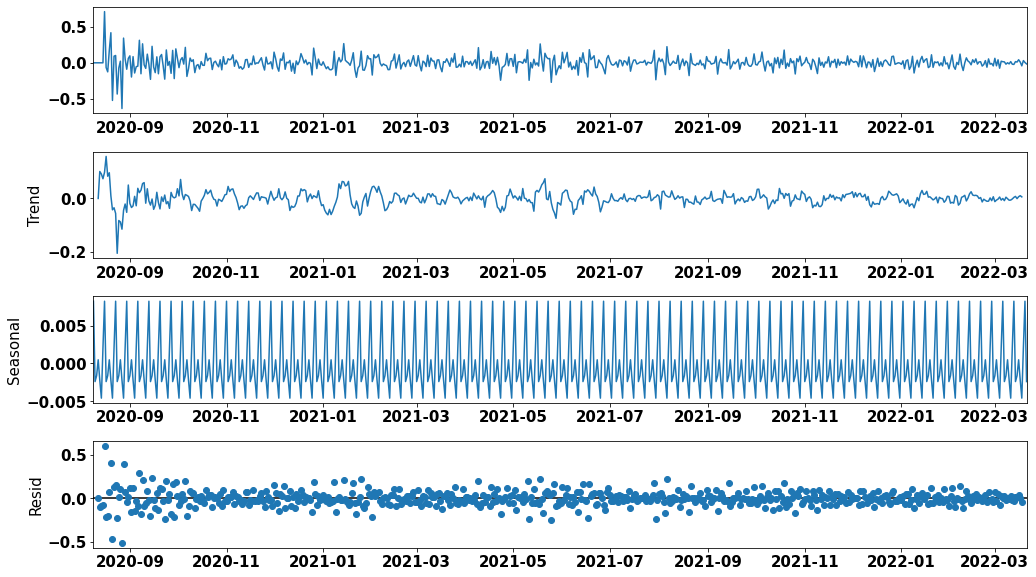

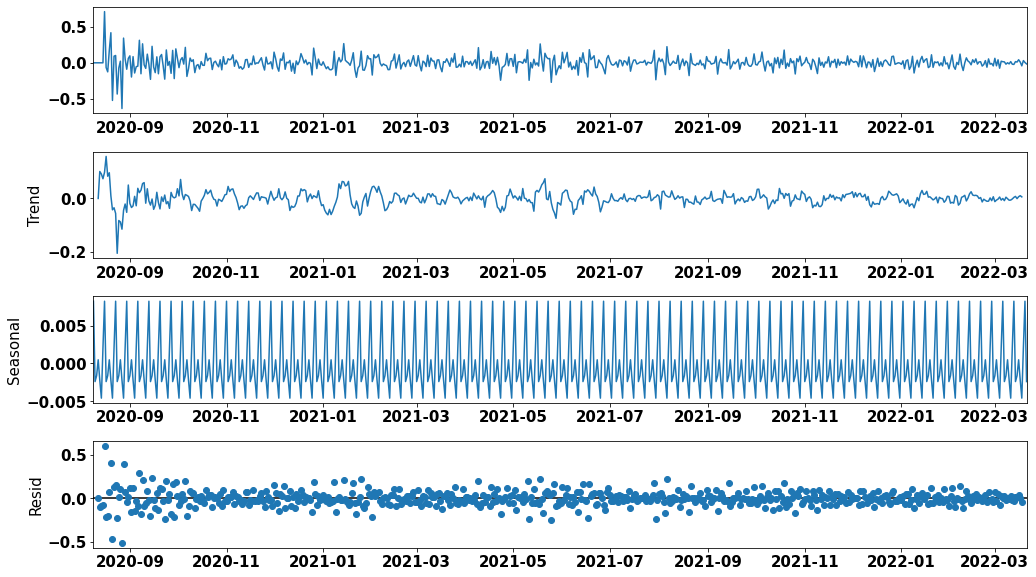

In [49]:
components = seasonal_decompose(olsr_resid_diff_1_7)
components.plot()

In [50]:
X_train1

Intercept  rna_value  rna_lag_1  rna_lag_2  rna_lag_3  \
DateTimeIndex                                                          
2020-08-08           1.0   4.999960   4.920312   4.847423   4.754139   
2020-08-09           1.0   4.934853   4.934853   4.934853   4.934853   
2020-08-10           1.0   4.824193   4.824193   4.824193   4.824193   
2020-08-11           1.0   4.806228   4.806228   4.806228   4.806228   
2020-08-12           1.0   4.777653   4.777653   4.777653   4.777653   
...                  ...        ...        ...        ...        ...   
2022-03-17           1.0   5.157272   5.157272   5.155561   5.155561   
2022-03-18           1.0   5.162661   5.162661   5.164260   5.164260   
2022-03-19           1.0   5.162661   5.162661   5.162661   5.162661   
2022-03-20           1.0   5.162661   5.162661   5.162661   5.162661   
2022-03-21           1.0   5.154925   5.154925   5.157305   5.157305   

               rna_lag_4  rna_lag_5  rna_lag_6  rna_lag_7  NHS_Borders  ...  \
DateTimeIndex                                                           ...   
2020-08-08      4.643896   4.530773   4.404811   4.258020          1.0  ...   
2020-08-09      4.934853   4.934853   4.934853   4.934853          1.0  ...   
2020-08-10      4.824193   4.824193   4.891627   4.956117          1.0  ...   
2020-08-11      4.806228   4.806228   4.806228   4.806228          1.0  ...   
2020-08-12      4.806228   4.806228   4.806228   4.806228          1.0  ...   
...                  ...        ...        ...        ...          ...  ...   
2022-03-17      5.157473   5.156514   5.150268   5.138421          1.0  ...   
2022-03-18      5.164260   5.162688   5.162688   5.165950          1.0  ...   
2022-03-19      5.162661   5.162661   5.162661   5.162661          1.0  ...   
2022-03-20      5.162661   5.162661   5.162661   5.162661          1.0  ...   
2022-03-21      5.157305   5.161911   5.161216   5.165629          1.0  ...   

               NHS_Grampian  NHS_Greater_Glasgow_and_Clyde  NHS_Highland  \
DateTimeIndex                                                              
2020-08-08              1.0                            1.0           1.0   
2020-08-09              1.0                            1.0           1.0   
2020-08-10              1.0                            1.0           1.0   
2020-08-11              1.0                            1.0           1.0   
2020-08-12              1.0                            1.0           1.0   
...                     ...                            ...           ...   
2022-03-17              1.0                            1.0           1.0   
2022-03-18              1.0                            1.0           1.0   
2022-03-19              1.0                            1.0           1.0   
2022-03-20              1.0                            1.0           1.0   
2022-03-21              1.0                            1.0           1.0   

               NHS_Lanarkshire  NHS_Lothian  NHS_Orkney  NHS_Shetland  \
DateTimeIndex                                                           
2020-08-08                 1.0          1.0         1.0           1.0   
2020-08-09                 1.0          1.0         1.0           1.0   
2020-08-10                 1.0          1.0         1.0           1.0   
2020-08-11                 1.0          1.0         1.0           1.0   
2020-08-12                 1.0          1.0         1.0           1.0   
...                        ...          ...         ...           ...   
2022-03-17                 1.0          1.0         1.0           1.0   
2022-03-18                 1.0          1.0         1.0           1.0   
2022-03-19                 1.0          1.0         1.0           1.0   
2022-03-20                 1.0          1.0         1.0           1.0   
2022-03-21                 1.0          1.0         1.0           1.0   

               NHS_Tayside  NHS_Western_Isles  weekday  
DateTimeIndex                                         

In [51]:

X_train_minus_intercept = X_train1.drop('Intercept', axis=1)
X_train_minus_intercept = X_train_minus_intercept.asfreq('D')

#y_train = y_train.asfreq('D')
X_train_minus_intercept


rna_value  rna_lag_1  rna_lag_2  rna_lag_3  rna_lag_4  \
DateTimeIndex                                                          
2020-08-08      4.999960   4.920312   4.847423   4.754139   4.643896   
2020-08-09      4.934853   4.934853   4.934853   4.934853   4.934853   
2020-08-10      4.824193   4.824193   4.824193   4.824193   4.824193   
2020-08-11      4.806228   4.806228   4.806228   4.806228   4.806228   
2020-08-12      4.777653   4.777653   4.777653   4.777653   4.806228   
...                  ...        ...        ...        ...        ...   
2022-03-17      5.157272   5.157272   5.155561   5.155561   5.157473   
2022-03-18      5.162661   5.162661   5.164260   5.164260   5.164260   
2022-03-19      5.162661   5.162661   5.162661   5.162661   5.162661   
2022-03-20      5.162661   5.162661   5.162661   5.162661   5.162661   
2022-03-21      5.154925   5.154925   5.157305   5.157305   5.157305   

               rna_lag_5  rna_lag_6  rna_lag_7  NHS_Borders  \
DateTimeIndex                                                 
2020-08-08      4.530773   4.404811   4.258020          1.0   
2020-08-09      4.934853   4.934853   4.934853          1.0   
2020-08-10      4.824193   4.891627   4.956117          1.0   
2020-08-11      4.806228   4.806228   4.806228          1.0   
2020-08-12      4.806228   4.806228   4.806228          1.0   
...                  ...        ...        ...          ...   
2022-03-17      5.156514   5.150268   5.138421          1.0   
2022-03-18      5.162688   5.162688   5.165950          1.0   
2022-03-19      5.162661   5.162661   5.162661          1.0   
2022-03-20      5.162661   5.162661   5.162661          1.0   
2022-03-21      5.161911   5.161216   5.165629          1.0   

               NHS_Dumfries_and_Galloway  ...  NHS_Grampian  \
DateTimeIndex                             ...                 
2020-08-08                           1.0  ...           1.0   
2020-08-09                           1.0  ...           1.0   
2020-08-10                           1.0  ...           1.0   
2020-08-11                           1.0  ...           1.0   
2020-08-12                           1.0  ...           1.0   
...                                  ...  ...           ...   
2022-03-17                           1.0  ...           1.0   
2022-03-18                           1.0  ...           1.0   
2022-03-19                           1.0  ...           1.0   
2022-03-20                           1.0  ...           1.0   
2022-03-21                           1.0  ...           1.0   

               NHS_Greater_Glasgow_and_Clyde  NHS_Highland  NHS_Lanarkshire  \
DateTimeIndex                                                                 
2020-08-08                               1.0           1.0              1.0   
2020-08-09                               1.0           1.0              1.0   
2020-08-10                               1.0           1.0              1.0   
2020-08-11                               1.0           1.0              1.0   
2020-08-12                               1.0           1.0              1.0   
...                                      ...           ...              ...   
2022-03-17                               1.0           1.0              1.0   
2022-03-18                               1.0           1.0              1.0   
2022-03-19                               1.0           1.0              1.0   
2022-03-20                               1.0           1.0              1.0   
2022-03-21                               1.0           1.0              1.0   

               NHS_Lothian  NHS_Orkney  NHS_Shetland  NHS_Tayside  \
DateTimeIndex                                                       
2020-08-08             1.0         1.0           1.0          1.0   
2020-08-09             1.0         1.0           1.0          1.0   
2020-08-10             1.0         1.0           1.0          1.0   
2020-08-11             1.0         1.0           1.0          1.0

In [52]:
warnings.simplefilter('ignore', ConvergenceWarning)
sarimax_model = ARIMA(endog=y_train1, exog=X_train_minus_intercept,order=(0,1,1), seasonal_order=(1,1,0,7))
sarimax_results = sarimax_model.fit()

#print(sarimax_results.mle_retvals)
for table in sarimax_results.summary().tables:
    print(table.as_latex_tabular())
#p value of ljung-box test decreased and skewness and kurtosis decreased than previous model so this is the best model7
sarimax_results.summary()

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}   &        DailyPositive         & \textbf{  No. Observations:  } &    591     \\
\textbf{Model:}           & ARIMA(0, 1, 1)x(1, 1, [], 7) & \textbf{  Log Likelihood     } &  1082.046  \\
\textbf{Date:}            &       Wed, 07 Sep 2022       & \textbf{  AIC                } & -2114.091  \\
\textbf{Time:}            &           16:28:57           & \textbf{  BIC                } & -2004.887  \\
\textbf{Sample:}          &          08-08-2020          & \textbf{  HQIC               } & -2071.526  \\
\textbf{}                 &         - 03-21-2022         & \textbf{                     } &            \\
\textbf{Covariance Type:} &             opg              & \textbf{                     } &            \\
\bottomrule
\end{tabular}
%\caption{SARIMAX Results}
\end{center}
\begin{center}
\begin{tabular}{lcccccc}
\toprule
                                           & \textbf{coef} & \textbf{std err} & \textbf{z} & \tex

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                    DailyPositive   No. Observations:                  591
Model:             ARIMA(0, 1, 1)x(1, 1, [], 7)   Log Likelihood                1082.046
Date:                          Wed, 07 Sep 2022   AIC                          -2114.091
Time:                                  16:28:57   BIC                          -2004.887
Sample:                              08-08-2020   HQIC                         -2071.526
                                   - 03-21-2022                                         
Covariance Type:                            opg                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
rna_value                         0.0456      0.139      0.328      0.743      -0.227       0.318
rna_lag_1                        -0.3795      0.263     -1.441      0.149      -0.896       0.137
rna_lag_2                         0.2738      0.280      0.979      0.327      -0.274       0.822
rna_lag_3                         0.1559      0.185      0.842      0.400      -0.207       0.519
rna_lag_4                         0.1707      0.154      1.108      0.268      -0.131       0.473
rna_lag_5                        -0.4463      0.171     -2.613      0.009      -0.781      -0.112
rna_lag_6                         0.0221      0.133      0.166      0.868      -0.238       0.283
rna_lag_7                         0.1025      0.054      1.911      0.056      -0.003       0.208
NHS_Borders                   -3.311e-10   3.95e-09     -0.084      0.933   -8.07e-09    7.41e-09
NHS_Dumfries_and_Galloway     -3.311e-10   3.95e-09     -0.084      0.933   -8.07e-09    7.41e-09
NHS_Fife                      -3.311e-10   3.95e-09     -0.084      0.933   -8.07e-09    7.41e-09
NHS_Forth_Valley              -3.311e-10   3.95e-09     -0.084      0.933   -8.07e-09    7.41e-09
NHS_Grampian                  -3.311e-10   3.95e-09     -0.084      0.933   -8.07e-09    7.41e-09
NHS_Greater_Glasgow_and_Clyde -3.311e-10   3.95e-09     -0.084      0.933   -8.07e-09    7.41e-09
NHS_Highland                  -3.311e-10   3.95e-09     -0.084      0.933   -8.07e-09    7.41e-09
NHS_Lanarkshire               -3.311e-10   3.95e-09     -0.084      0.933   -8.07e-09    7.41e-09
NHS_Lothian                   -3.311e-10   3.95e-09     -0.084      0.933   -8.07e-09    7.41e-09
NHS_Orkney                    -3.311e-10   3.95e-09     -0.084      0.933   -8.07e-09    7.41e-09
NHS_Shetland                  -3.311e-10   3.95e-09     -0.084      0.933   -8.07e-09    7.41e-09
NHS_Tayside                   -3.311e-10   3.95e-09     -0.084      0.933   -8.07e-09    7.41e-09
NHS_Western_Isles              2.279e-11   3.95e-09      0.006      0.995   -7.72e-09    7.77e-09
weekday                       -3.763e-08   2.24e-08     -1.682      0.093   -8.15e-08    6.23e-09
ma.L1                            -0.3948      0.027    -14.471      0.000      -0.448      -0.341
ar.S.L7                          -0.3618      0.034    -10.500      0.000      -0.429      -0.294
sigma2                            0.0014   5.15e-05     27.696      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               639.59
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                 

In [53]:
X_test_minus_intercept = X_test1.drop('Intercept', axis=1)
X_test_minus_intercept = X_test_minus_intercept.asfreq('D')
y_test1 = y_test1.asfreq('D')
y_test1

DailyPositive
DateTimeIndex               
2022-03-22          4.469910
2022-03-23          4.465934
2022-03-24          4.442158
2022-03-25          4.417262
2022-03-26          4.383817
2022-03-27          4.401088
2022-03-28          4.440731
2022-03-29          4.430318
2022-03-30          4.403801
2022-03-31          4.367530
2022-04-01          4.341336
2022-04-02          4.316559
2022-04-03          4.331323
2022-04-04          4.380431
2022-04-05          4.380569
2022-04-06          4.369907
2022-04-07          4.355227
2022-04-08          4.316016
2022-04-09          4.281998
2022-04-10          4.320357
2022-04-11          4.349948
2022-04-12          4.340895
2022-04-13          4.333494
2022-04-14          4.308205
2022-04-15          4.269409
2022-04-16          4.245490
2022-04-17          4.256966
2022-04-18          4.283190
2022-04-19          4.288007
2022-04-20          4.269988

In [54]:
predictions = sarimax_results.get_forecast(steps=30, exog=X_test_minus_intercept[:30])
y_pred1=predictions.predicted_mean
y_pred1
predictions.summary_frame()
#print(predictions.summary_frame().to_latex())

DailyPositive      mean   mean_se  mean_ci_lower  mean_ci_upper
2022-03-22     4.482812  0.037763       4.408797       4.556827
2022-03-23     4.470865  0.044141       4.384349       4.557381
2022-03-24     4.456201  0.049708       4.358775       4.553627
2022-03-25     4.429186  0.054711       4.321954       4.536417
2022-03-26     4.420807  0.059293       4.304594       4.537020
2022-03-27     4.446553  0.063546       4.322005       4.571101
2022-03-28     4.479408  0.067531       4.347049       4.611767
2022-03-29     4.479796  0.082251       4.318586       4.641006
2022-03-30     4.464882  0.090373       4.287755       4.642009
2022-03-31     4.446403  0.097822       4.254675       4.638130
2022-04-01     4.420521  0.104743       4.215229       4.625813
2022-04-02     4.415473  0.111234       4.197459       4.633488
2022-04-03     4.441262  0.117367       4.211228       4.671297
2022-04-04     4.476711  0.123194       4.235254       4.718167
2022-04-05     4.476474  0.139990       4.202099       4.750849
2022-04-06     4.465913  0.150414       4.171107       4.760720
2022-04-07     4.449140  0.160162       4.135230       4.763051
2022-04-08     4.418693  0.169349       4.086775       4.750610
2022-04-09     4.414190  0.178063       4.065194       4.763186
2022-04-10     4.439963  0.186369       4.074686       4.805241
2022-04-11     4.470702  0.194321       4.089839       4.851565
2022-04-12     4.472711  0.211021       4.059117       4.886306
2022-04-13     4.464660  0.222811       4.027959       4.901361
2022-04-14     4.442811  0.234007       3.984166       4.901456
2022-04-15     4.417309  0.244691       3.937724       4.896895
2022-04-16     4.407924  0.254928       3.908274       4.907574
2022-04-17     4.433703  0.264770       3.914764       4.952642
2022-04-18     4.468443  0.274258       3.930907       5.005979
2022-04-19     4.471122  0.291722       3.899358       5.042886
2022-04-20     4.458676  0.304822       3.861235       5.056117

In [55]:
predict=pd.concat([y_test1, y_pred1], axis=1)
mse = ((predict["predicted_mean"] - predict["DailyPositive"]) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 0.01
The Root Mean Squared Error of our forecasts is 0.11


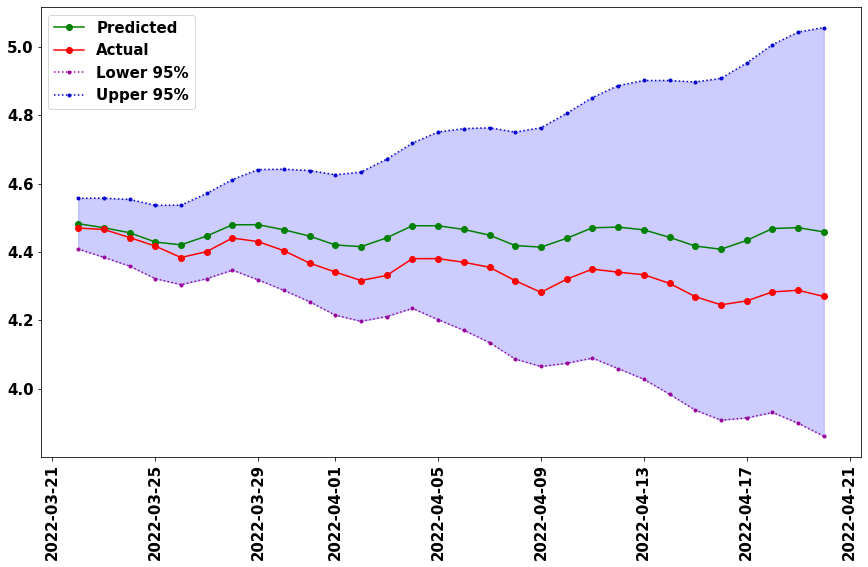

In [56]:
font = {'family' : 'DejaVu Sans',
        'size'   : 15}

plt.rc('font', **font)
predicted, = plt.plot(X_test_minus_intercept[:30].index, predictions.summary_frame()['mean'], 'go-', label='Predicted')
 
actual, = plt.plot(X_test_minus_intercept[:30].index, y_test1[:30], 'ro-', label='Actual')
 
lower, = plt.plot(X_test_minus_intercept[:30].index, predictions.summary_frame()['mean_ci_lower'], color='#990099', marker='.', linestyle=':', label='Lower 95%')
 
upper, = plt.plot(X_test_minus_intercept[:30].index, predictions.summary_frame()['mean_ci_upper'], color='#0000cc', marker='.', linestyle=':', label='Upper 95%')

plt.fill_between(X_test_minus_intercept[:30].index, predictions.summary_frame()['mean_ci_lower'], predictions.summary_frame()['mean_ci_upper'], color = 'b', alpha = 0.2)
 
plt.legend(handles=[predicted, actual, lower, upper])

plt.xticks(rotation=90)

plt.savefig('pred_act.png',bbox_inches='tight')

# Early Detection

Importing file with daily cases in Scotland

In [57]:
df_cum=pd.read_csv('covid_daily_cumulative_cases.csv', header=0)
df_cum

Country      Date  DailyCases  CumulativeCases
0    S92000003  20200301           2                3
1    S92000003  20200302           1                4
2    S92000003  20200303           3                7
3    S92000003  20200304           6               13
4    S92000003  20200305           2               15
..         ...       ...         ...              ...
871  S92000003  20220720        1478          2063588
872  S92000003  20220721        1225          2064813
873  S92000003  20220722        1058          2065871
874  S92000003  20220723         918          2066789
875  S92000003  20220724         923          2067712

[876 rows x 4 columns]

In [58]:
ts = ewstools.core.TimeSeries(data=df_cum["DailyCases"],transition=668)
ts
ts.detrend(method='Lowess', span=0.1)
#ts.state.plot()
ts.compute_var(rolling_window=0.5)
ts.compute_auto(lag=1, rolling_window=0.5)
ts.compute_skew(rolling_window=0.5)
ts.compute_cv(rolling_window=0.5)
ts.ews.dropna()
ts.compute_ktau()
ts.ktau
ts.make_plotly()
fig=ts.make_plotly(kendall_tau=True)
fig
#plt.savefig('ew.png')

In [59]:
df_all['rna_lag_8'] = df_all['rna_value'].shift(8)
dataset_len = len(df_all)
split_index = round(dataset_len*0.95)
train_set_end_date = df_all.index[split_index]
df_train1 = df_all.loc[df_all.index <= train_set_end_date].copy()
df_test1 = df_all.loc[df_all.index > train_set_end_date].copy()
df_test1['rna_lag_7']

DateTimeIndex
2022-03-21    13.780740
2022-03-21    13.014595
2022-03-21    13.224221
2022-03-21    12.487802
2022-03-21     9.160415
                ...    
2022-04-20    11.657104
2022-04-20    12.126407
2022-04-20    12.020845
2022-04-20    10.755306
2022-04-20    11.173729
Name: rna_lag_7, Length: 434, dtype: float64

In [60]:
expr = 'DailyPositive ~ rna_lag_8+rna_lag_7+NHS_Borders+NHS_Dumfries_and_Galloway+NHS_Fife+NHS_Forth_Valley+NHS_Grampian+NHS_Greater_Glasgow_and_Clyde+NHS_Highland+NHS_Lanarkshire+NHS_Lothian+NHS_Orkney+NHS_Shetland+NHS_Tayside+NHS_Western_Isles'

y_train1, X_train1 = dmatrices(expr, df_train1, return_type='dataframe')
y_test1, X_test1 = dmatrices(expr, df_test1, return_type='dataframe')
olsr_results = linear_model.OLS(y_train1, X_train1).fit()
olsr_results.summary()
print(olsr_results.summary())
for table in olsr_results.summary().tables:
    print(table.as_latex_tabular())
olsr_results.summary()

                            OLS Regression Results                            
Dep. Variable:          DailyPositive   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     1566.
Date:                Wed, 07 Sep 2022   Prob (F-statistic):               0.00
Time:                        16:28:58   Log-Likelihood:                -11164.
No. Observations:                8252   AIC:                         2.236e+04
Df Residuals:                    8236   BIC:                         2.247e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          DailyPositive   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     1566.
Date:                Wed, 07 Sep 2022   Prob (F-statistic):               0.00
Time:                        16:28:58   Log-Likelihood:                -11164.
No. Observations:                8252   AIC:                         2.236e+04
Df Residuals:                    8236   BIC:                         2.247e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.6694      0.061     11.022      0.000       0.550       0.788
rna_lag_8                         0.2060      0.005     43.222      0.000       0.197       0.215
rna_lag_7                         0.1794      0.005     37.633      0.000       0.170       0.189
NHS_Borders                      -1.5137      0.056    -27.272      0.000      -1.622      -1.405
NHS_Dumfries_and_Galloway        -1.5175      0.055    -27.679      0.000      -1.625      -1.410
NHS_Fife                          0.3860      0.056      6.853      0.000       0.276       0.496
NHS_Forth_Valley                  1.3293      0.058     23.114      0.000       1.217       1.442
NHS_Grampian                      0.8604      0.061     14.163      0.000       0.741       0.980
NHS_Greater_Glasgow_and_Clyde     1.9594      0.057     34.421      0.000       1.848       2.071
NHS_Highland                      0.1245      0.059      2.107      0.035       0.009       0.240
NHS_Lanarkshire                   1.0108      0.055     18.489      0.000       0.904       1.118
NHS_Lothian                       1.2648      0.055     23.018      0.000       1.157       1.373
NHS_Orkney                       -2.5813      0.056    -46.237      0.000      -2.691      -2.472
NHS_Shetland                     -2.8116      0.055    -51.370      0.000      -2.919      -2.704
NHS_Tayside                      -0.0520      0.055     -0.949      0.343      -0.159       0.055
NHS_Western_Isles                -2.8033      0.055    -50.975      0.000      -2.911      -2.696
==============================================================================
Omnibus:                      457.863   Durbin-Watson:                   0.825
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1082.061
Skew:                          -0.343   Prob(JB):                    1.08e-235
Kurtosis:                       4.636   Cond. No.                         203.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

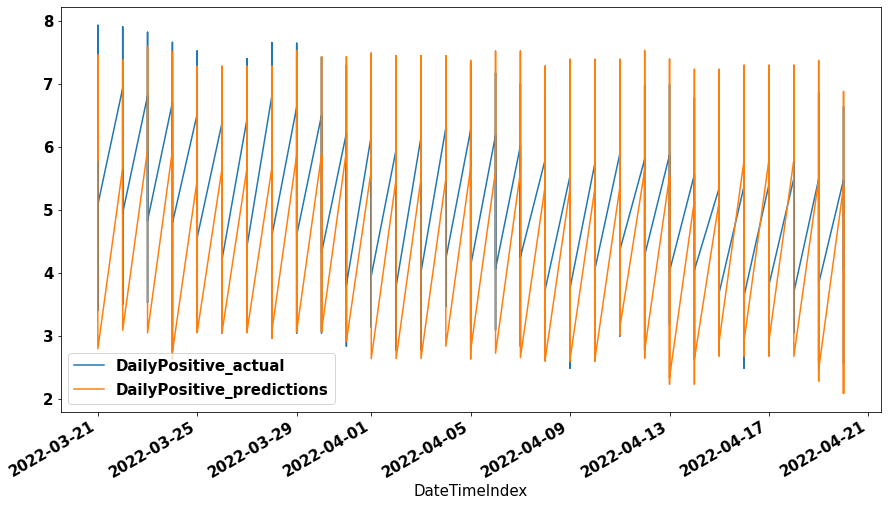

In [61]:
y_pred=olsr_results.predict(X_test1)
y_pred=pd.DataFrame(y_pred)
pred=pd.concat([y_test1, y_pred], axis=1)
mapping = {pred.columns[0]:'DailyPositive_actual', pred.columns[1]: 'DailyPositive_predictions'}
pred = pred.rename(columns=mapping)
pred
pred.plot(use_index=True)
plt.savefig('pred_week.png')

In [62]:
res=olsr_results.resid

C:\Users\simon\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



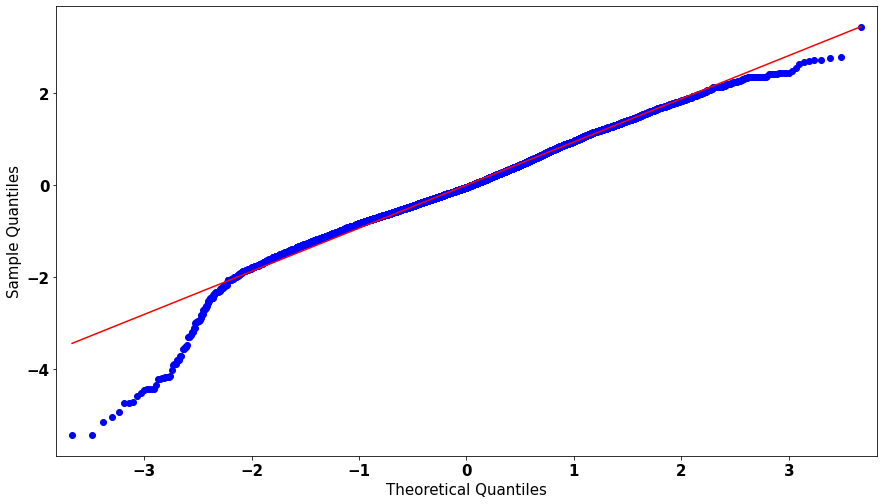

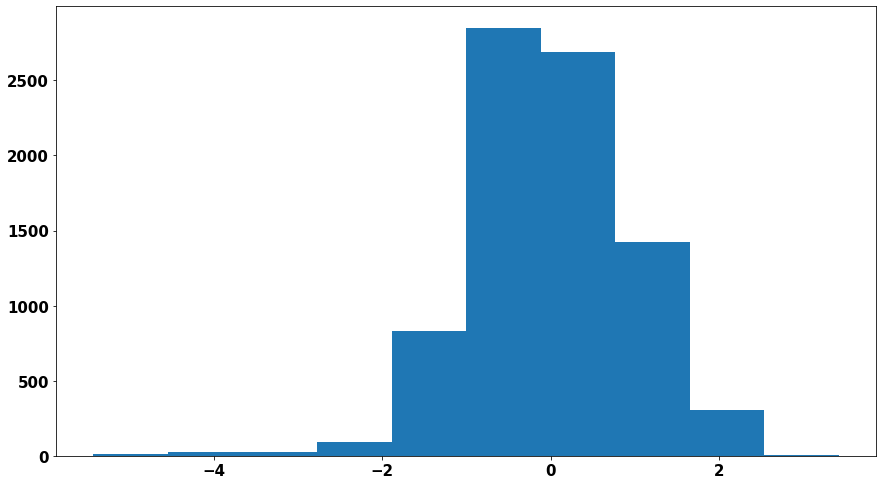

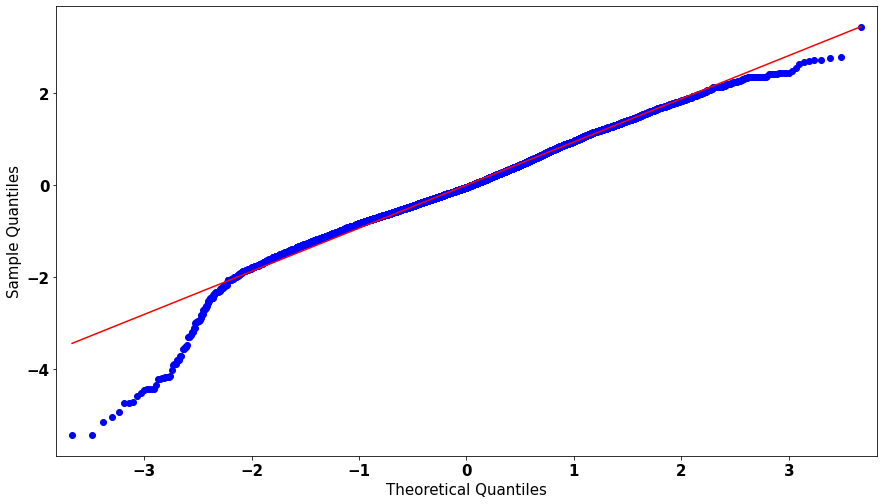

In [63]:
pyplot.hist(res)
qqplot(res,line='s')

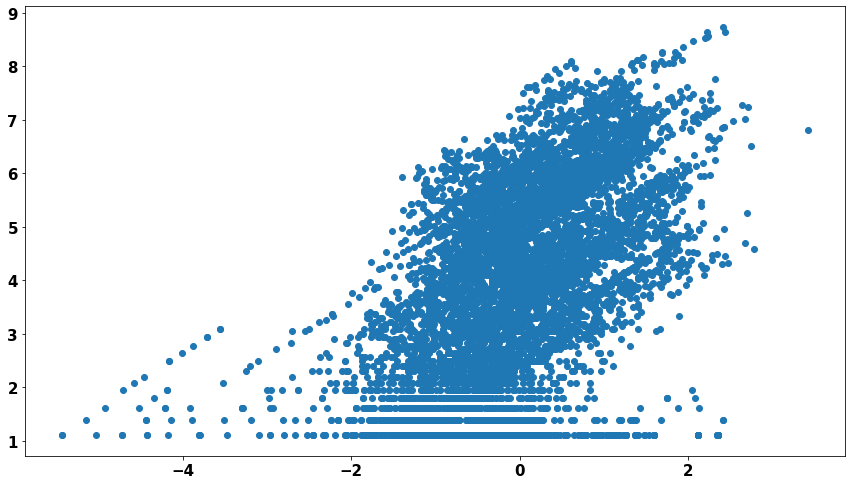

In [64]:
pyplot.scatter(res,y_train1)